In [ ]:
from torch.optim import AdamW
from transformers import AutoProcessor, AutoModelForTokenClassification,LayoutLMv3FeatureExtractor,LayoutLMv3Tokenizer
import torch
import os
from pathlib import Path
import pandas as pd
from ast import literal_eval
from PIL import Image, ImageDraw, Image, ImageFont, ImageColor, ImageOps
import json
from torch.optim.lr_scheduler import StepLR
from sklearn.utils import shuffle
import random

In [ ]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [3]:
df = pd.read_csv('training_data.csv')
df

,questions,words,boxes,images
0,"['Job:', 'Company:', 'Ssn:', 'Residence:', 'Cu...","[['Tax', 'adviser'], ['Matthews'], ['470-65-07...","[[[105, 48, 138, 59], [145, 48, 209, 59]], [[1...",/home/delta/vscode/dataextraction/Question_Ans...
1,"['Job:', 'Company:', 'Ssn:', 'Residence:', 'Cu...","[['Camera', 'operator'], ['Hill,', 'Bright', '...","[[[106, 48, 176, 59], [183, 49, 257, 61]], [[1...",/home/delta/vscode/dataextraction/Question_Ans...
2,"['Job:', 'Company:', 'Residence:', 'Current_lo...","[['Insurance', 'risk', 'surveyor'], ['Gomez,',...","[[[107, 48, 192, 59], [200, 48, 230, 59], [237...",/home/delta/vscode/dataextraction/Question_Ans...
3,"['Job:', 'Company:', 'Ssn:', 'Residence:', 'Cu...","[['Civil', 'Service', 'fast', 'streamer'], ['C...","[[[106, 48, 142, 59], [149, 48, 215, 59], [222...",/home/delta/vscode/dataextraction/Question_Ans...
4,"['Job:', 'Ssn:', 'Residence:', 'Current_locati...","[['Ceramics', 'designer', 'Deleon,', 'Hensley'...","[[[106, 48, 189, 59], [196, 48, 273, 61], [160...",/home/delta/vscode/dataextraction/Question_Ans...
5,"['Job:', 'Company:', 'Residence:', 'Current_lo...","[['technologist'], ['Reyes', 'and', 'Sons', '5...","[[[170, 46, 277, 63]], [[161, 77, 215, 90], [2...",/home/delta/vscode/dataextraction/Question_Ans...
6,"['Job:', 'Company:', 'Ssn:', 'Residence:', 'Cu...","[['Translator'], ['Salazar,', 'Contreras', 'an...","[[[105, 48, 195, 59]], [[160, 76, 231, 89], [2...",/home/delta/vscode/dataextraction/Question_Ans...
7,"['Job:', 'Company:', 'Ssn:', 'Residence:', 'Cu...","[['Chief', 'Financial'], ['Lee,', 'Greer', 'an...","[[[106, 48, 152, 59], [159, 48, 237, 59]], [[1...",/home/delta/vscode/dataextraction/Question_Ans...
8,"['Job:', 'Company:', 'Residence:', 'Current_lo...","[['Land'], ['Evans-Bruce', '103-91-7068'], ['7...","[[[107, 48, 149, 59]], [[160, 77, 273, 88], [1...",/home/delta/vscode/dataextraction/Question_Ans...
9,"['Job:', 'Company:', 'Ssn:', 'Residence:', 'Cu...","[['Scientist,', 'audiological'], ['Daniels-Obr...","[[[106, 48, 185, 61], [193, 48, 298, 61]], [[1...",/home/delta/vscode/dataextraction/Question_Ans...


In [4]:
ignore_list = []
labels = []
for i,r in df.iterrows():
    words_page = literal_eval(r['words'])
    boxes_page = literal_eval(r['boxes'])
    questions_page = literal_eval(r['questions'])
    image = r['images']
    j = 0
    for question in questions_page:
        labels.append(question)
        if question == 'Username: Name:' or question =='Sex: Address:' or question == 'Mail: Birthdate:' or question == 'Ssn: Residence:':
            print(r['images']), print(question)
            # F UP a few annotation
            ignore_list.append(r['images'])
        j += 1
labels = list(dict.fromkeys(labels))

/home/delta/vscode/dataextraction/Question_Answer/Image/16_page_1.png
Username: Name:
/home/delta/vscode/dataextraction/Question_Answer/Image/5_page_1.png
Sex: Address:
/home/delta/vscode/dataextraction/Question_Answer/Image/8_page_1.png
Username: Name:
/home/delta/vscode/dataextraction/Question_Answer/Image/14_page_1.png
Mail: Birthdate:
/home/delta/vscode/dataextraction/Question_Answer/Image/15_page_1.png
Mail: Birthdate:
/home/delta/vscode/dataextraction/Question_Answer/Image/2_page_1.png
Username: Name:
/home/delta/vscode/dataextraction/Question_Answer/Image/7_page_1.png
Mail: Birthdate:
/home/delta/vscode/dataextraction/Question_Answer/Image/19_page_1.png
Ssn: Residence:


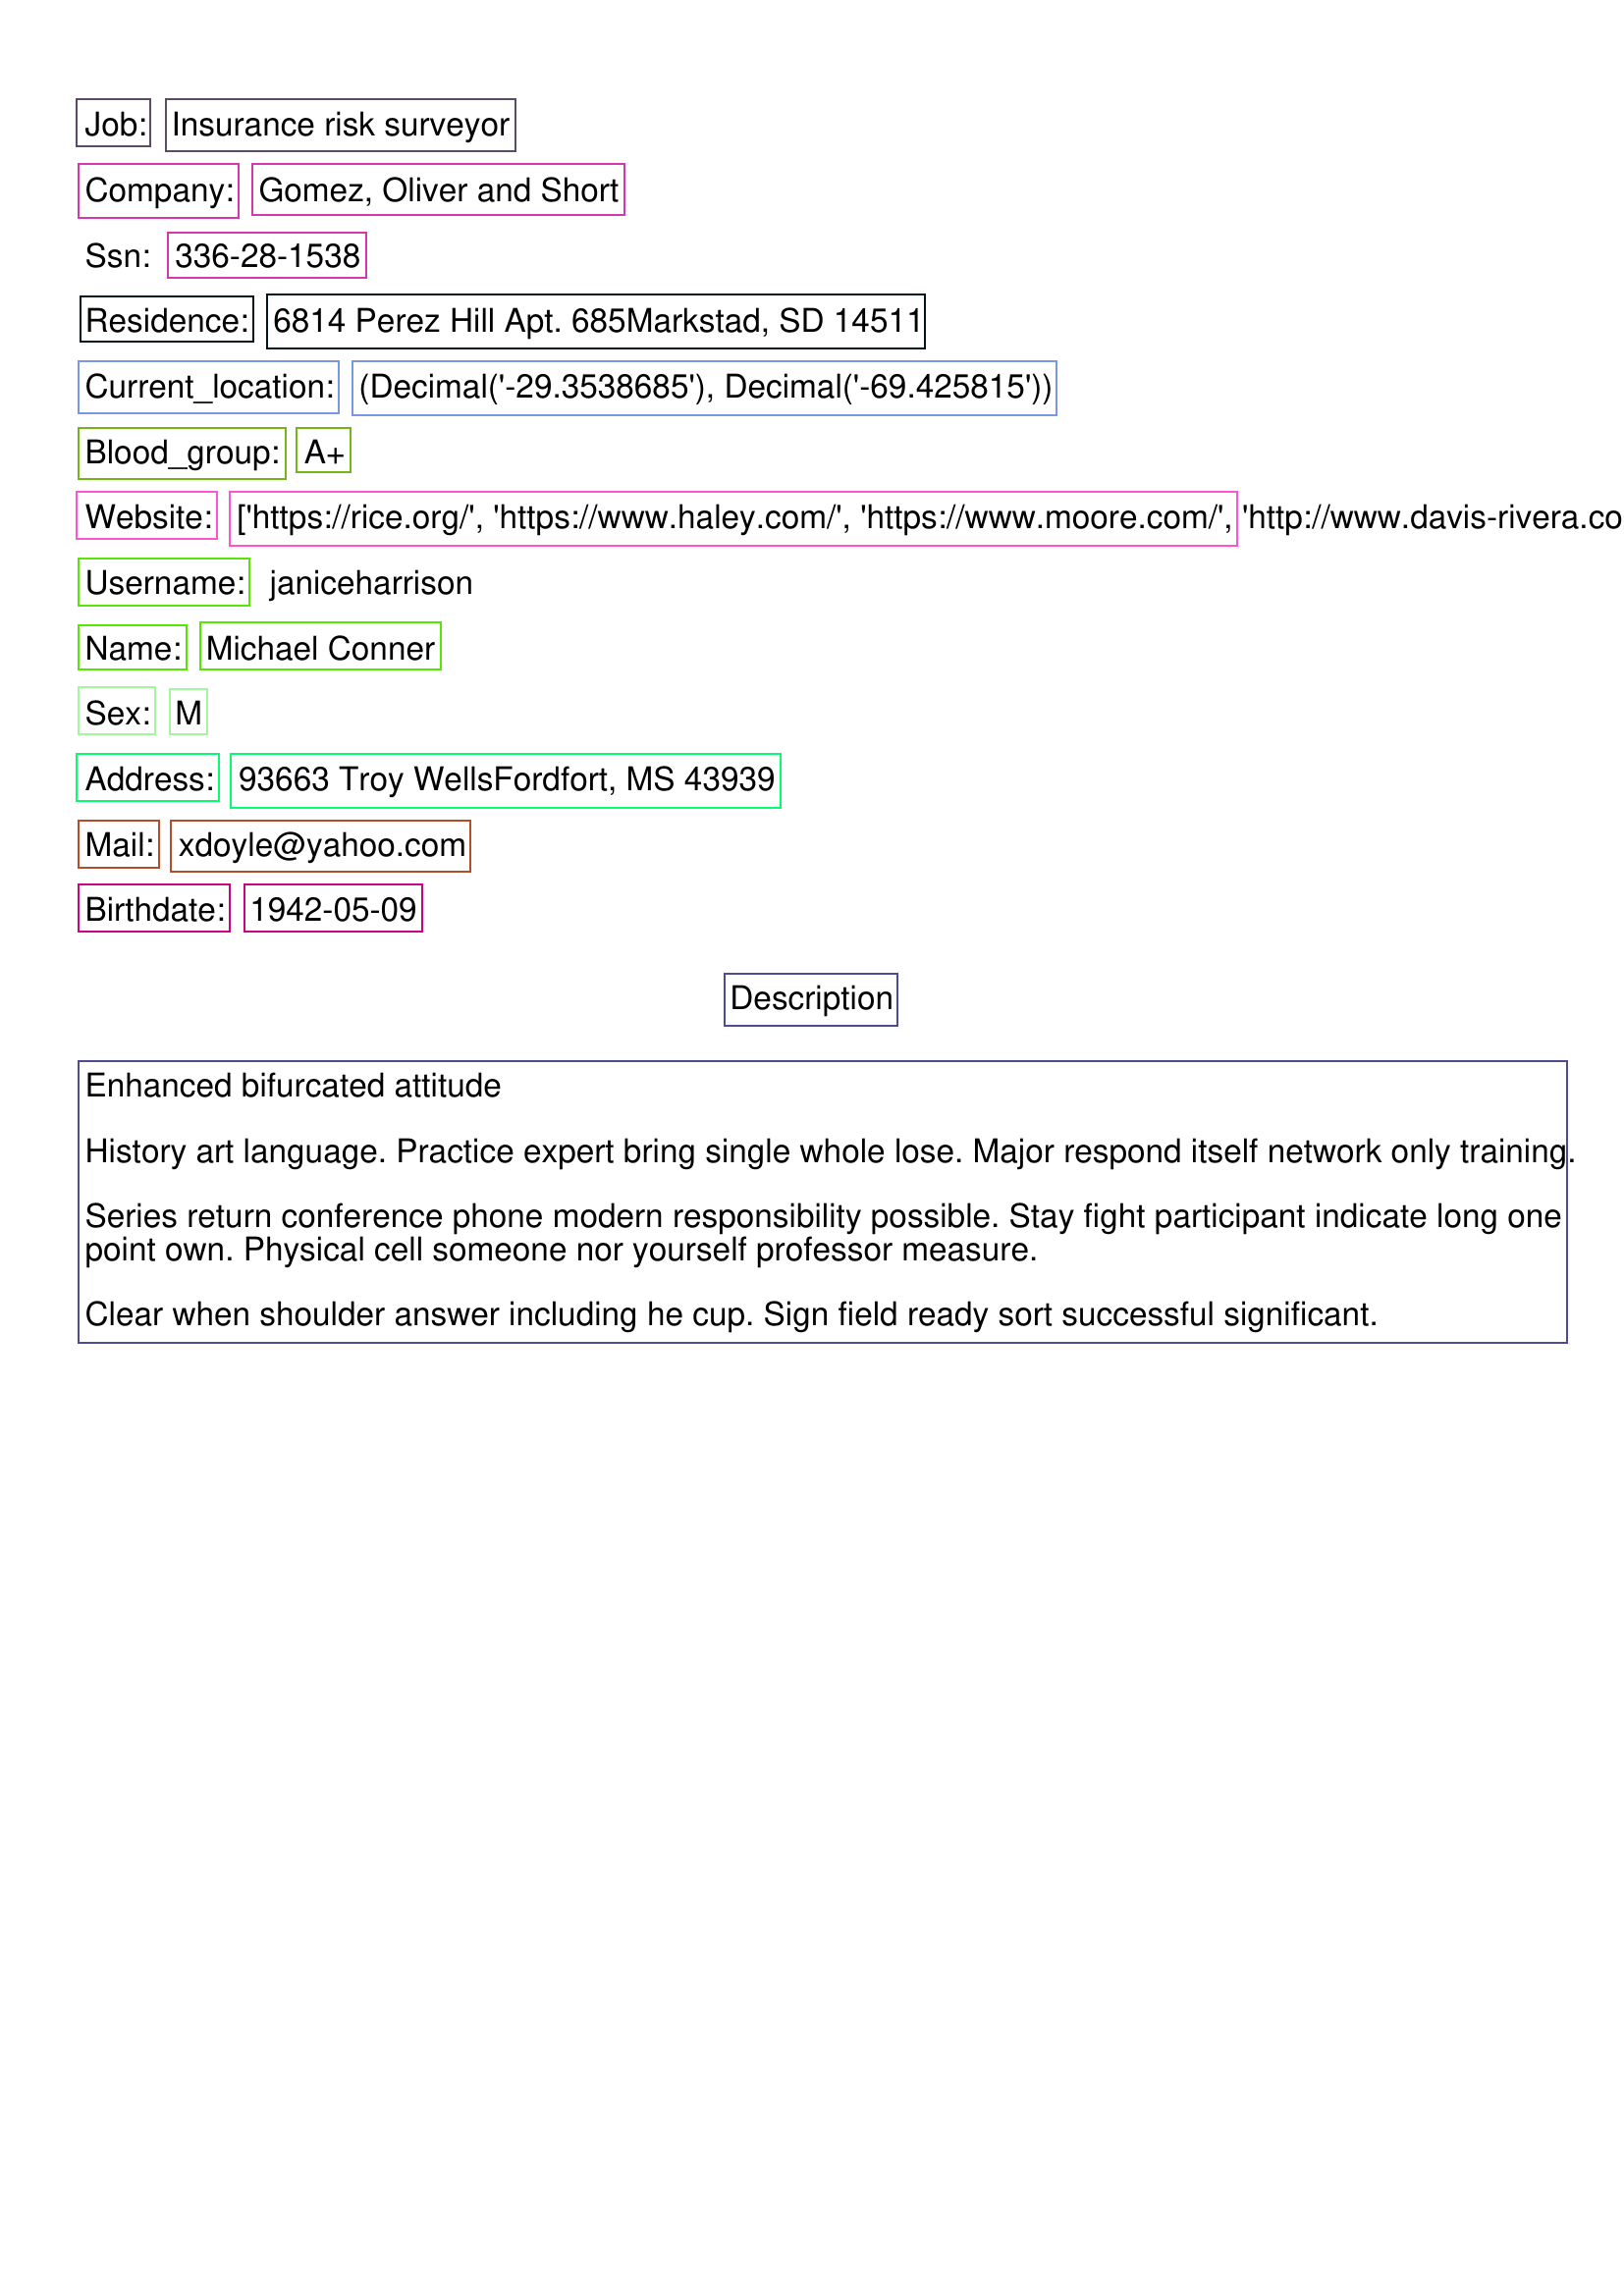

In [5]:
Image.open('/home/delta/vscode/dataextraction/Question_Answer/Image/16_page_1.png')

In [6]:
for f in ignore_list:
    df = df.loc[df['images']!= f]  #removed the f up annotations

In [7]:

labels = []
for i,r in df.iterrows():
    words_page = literal_eval(r['words'])
    boxes_page = literal_eval(r['boxes'])
    questions_page = literal_eval(r['questions'])
    image = r['images']
    assert len(words_page) == len(questions_page),len(questions_page) == len(boxes_page)
    
    for x in range(len(questions_page)):
        labels.append(questions_page[x])
labels = list(dict.fromkeys(labels))
label2dict = {}
dict2label = {}
for label, n in zip(labels, [i for i in range(len(labels))]):
    label2dict[label] = n
    dict2label[n] = label

In [100]:
%%capture
model = AutoModelForTokenClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=14)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimiser = AdamW(model.parameters(), lr=6e-5)
scheduler = StepLR(optimiser, step_size=1, gamma=0.85)
model.train()

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [101]:
Encodes = []
for i,r in df.iterrows():
    questions_page = literal_eval(r['questions'])
    questions_page = [label2dict[q] for q in questions_page]
    image = r['images']  
    image = Image.open(image)
    words_page = literal_eval(r['words'])
    boxes_page = literal_eval(r['boxes'])
    W = []
    B = []
    L = []
    for label,words,boxes in zip(questions_page,words_page,boxes_page):
        for w,b in zip(words,boxes):
            W.append(w)
            B.append(b)
            L.append(label)
            
    encoding = processor(image, W,boxes=B,word_labels=L, return_tensors="pt",padding=True, truncation=True)
    Encodes.append(encoding)

In [102]:
model.train()
total_loss = 0
n = 1
for epoch in range(30):
    for encoding in Encodes:
        outputs = model(**encoding.to(device))
        loss = outputs.loss
        total_loss += loss.item()
        if n % 10 == 0:
            print(n,round(total_loss/n,5))
            total_loss = 0
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        n += 1

10 1.82719
20 0.56464
30 0.26969
40 0.15006
50 0.06358
60 0.06659
70 0.05137
80 0.03544
90 0.03466
100 0.03111
110 0.0125
120 0.02056
130 0.01513
140 0.00627
150 0.00727
160 0.0087
170 0.00738
180 0.01024
190 0.00353
200 0.00286
210 0.00209
220 0.0014
230 0.0012
240 0.00108
250 0.00075
260 0.00057
270 0.0006
280 0.00061
290 0.00041
300 0.00038
310 0.00059
320 0.00058
330 0.0004
340 0.00034
350 0.00031
360 0.00063


In [103]:
model.save_pretrained('/home/delta/vscode/dataextraction/model')

In [104]:
model.eval()
tokenizer = LayoutLMv3Tokenizer.from_pretrained("microsoft/layoutlmv3-base")
features = LayoutLMv3FeatureExtractor()

In [217]:
def getBoundingBox(X):
    if type(X[0][0]) != list:
        X = [X]
    XX = []
    for ss in X:
        s1 = []
        s2 = []
        s3 = []
        s4 = []
        for s in ss:
            s1.append(int(s[0]))
            s2.append(int(s[1]))
            s3.append(int(s[2]))
            s4.append(int(s[3]))
        x1 = min(s1)-5
        y1 = min(s2)-5
        x2 = max(s3)+5
        y2 = max(s4)+5
        XX.append([x1,y1,x2,y2])
    return XX
def extractData(image):
    encoding = features(image)
    encoding = processor(image, encoding['words'],boxes=encoding['boxes'], return_tensors='pt')
    outputs = model(**encoding.to(device))
    outputs = [dict2label[s] for s in outputs.logits.argmax(-1).tolist()[0]]
    inputs = encoding['input_ids'][0]
    inputs = [processor.decode(i) for i in inputs]
    boxes = encoding['bbox'].cpu().tolist()[0]
    da = pd.DataFrame(columns=['inputs','outputs','boxes'])
    da['inputs'] = inputs
    da['outputs'] = outputs
    da['boxes'] = boxes
    ss =[" ['",'<s>',':','</s>','.','�']
    for s in ss:
        da = da.loc[da['inputs'] != s]
    daa = pd.DataFrame()
    daa['boxes'] = ''
    daa['boxes'] = daa['boxes'].astype(object)
    j = 0
    for i,r in da.iterrows():
        inputs = r['inputs']
        outputs = r['outputs']
        try:
            _ = outputs.index(inputs)
            _ = outputs.find(inputs)
        except:
            daa.at[j,'inputs'] = inputs
            daa.at[j,'outputs'] = outputs
            daa.at[j,'boxes'] = r['boxes']
            j += 1

    da = daa  
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)
    answer = pd.DataFrame(columns=['key','value'])
    l = 0
    for n,g in da.groupby('outputs'):
        pre = g['inputs'].values.tolist()
        pre = ''.join(pre)
        try:
            start = pre.index(n[:-1])
            start = start + len(n)
            pre = pre[start:]
            pre = pre.lstrip(' ').rstrip(' ')
            answer.at[l,'key'] = n
            answer.at[l,'value'] = pre
            l += 1
        except:
            pre = pre.lstrip(' ').rstrip(' ')
            answer.at[l,'key'] = n
            answer.at[l,'value'] = pre
            l += 1
        box = g['boxes'].values.tolist()
        color = tuple(random.choices(range(256), k=3))  
        for b in box:
            x1,y1,x2,y2 = b
            x1 = int(image.width*x1/1000)
            x2 = int(image.width*x2/1000)
            y1 = int(image.height*y1/1000)
            y2 = int(image.height*y2/1000)
            b = [x1,y1,x2,y2]
            draw.rectangle(b, outline=color, width=2)
            draw.text((b[0] + 10, b[1] - 10), n, fill=color, font=font)
    return answer, image
def generateonefakeppdf():
    from faker import Faker
    import warnings
    warnings.filterwarnings('ignore')
    from fpdf import FPDF
    import pdf2image
    fake = Faker()
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('helvetica', size=12)
    profile = fake.profile()
    profile.keys()
    for k in profile.keys():
        try:
            pdf.cell(txt=' ',ln=1)
            pdf.cell(txt=f'{k.capitalize()}:')
            pdf.cell(txt= f' {profile[k]}',ln=1)
        except:
            pass
    pdf.cell(txt=' ',ln=1)
    pdf.cell(0, 10, 'Description', 0, 0, 'C')
    pdf.ln(10)
    pdf.cell(txt=' ',ln=1)
    pdf.cell(txt= fake.catch_phrase(),ln=1)
    pdf.cell(txt=' ',ln=1)
    for p in fake.paragraphs():
        pdf.multi_cell(align='l',txt=p,w=200,ln=1)
        pdf.cell(txt=' ',ln=1)

    pdf.output(f"fakepdf.pdf")
    image = pdf2image.convert_from_path('fakepdf.pdf')[0]
    return image      

extracte data
                  key                                              value
0            Address:                47727 Brown ClubBakerberg, MI 47210
1          Birthdate:                                   Blood 1908-08-04
2        Blood_group:                                         O+ Website
3            Company:                     Wolf, Wilson and Alvarado Sman
4   Current_location:                                Dec Decimal110apcom
5         Description  Enterprise-wide fault-olerant hub First real d...
6                Job:                   Clinical research associategroup
7               Mail:                                keseymorrison@yahoo
8               Name:                                 Michele Nguyen Sex
9          Residence:  21-3246 Res 740 Elizabeth VillagesNorth Lindav...
10               Sex:                                                  F
11               Ssn:                                               550-
12          Username:                

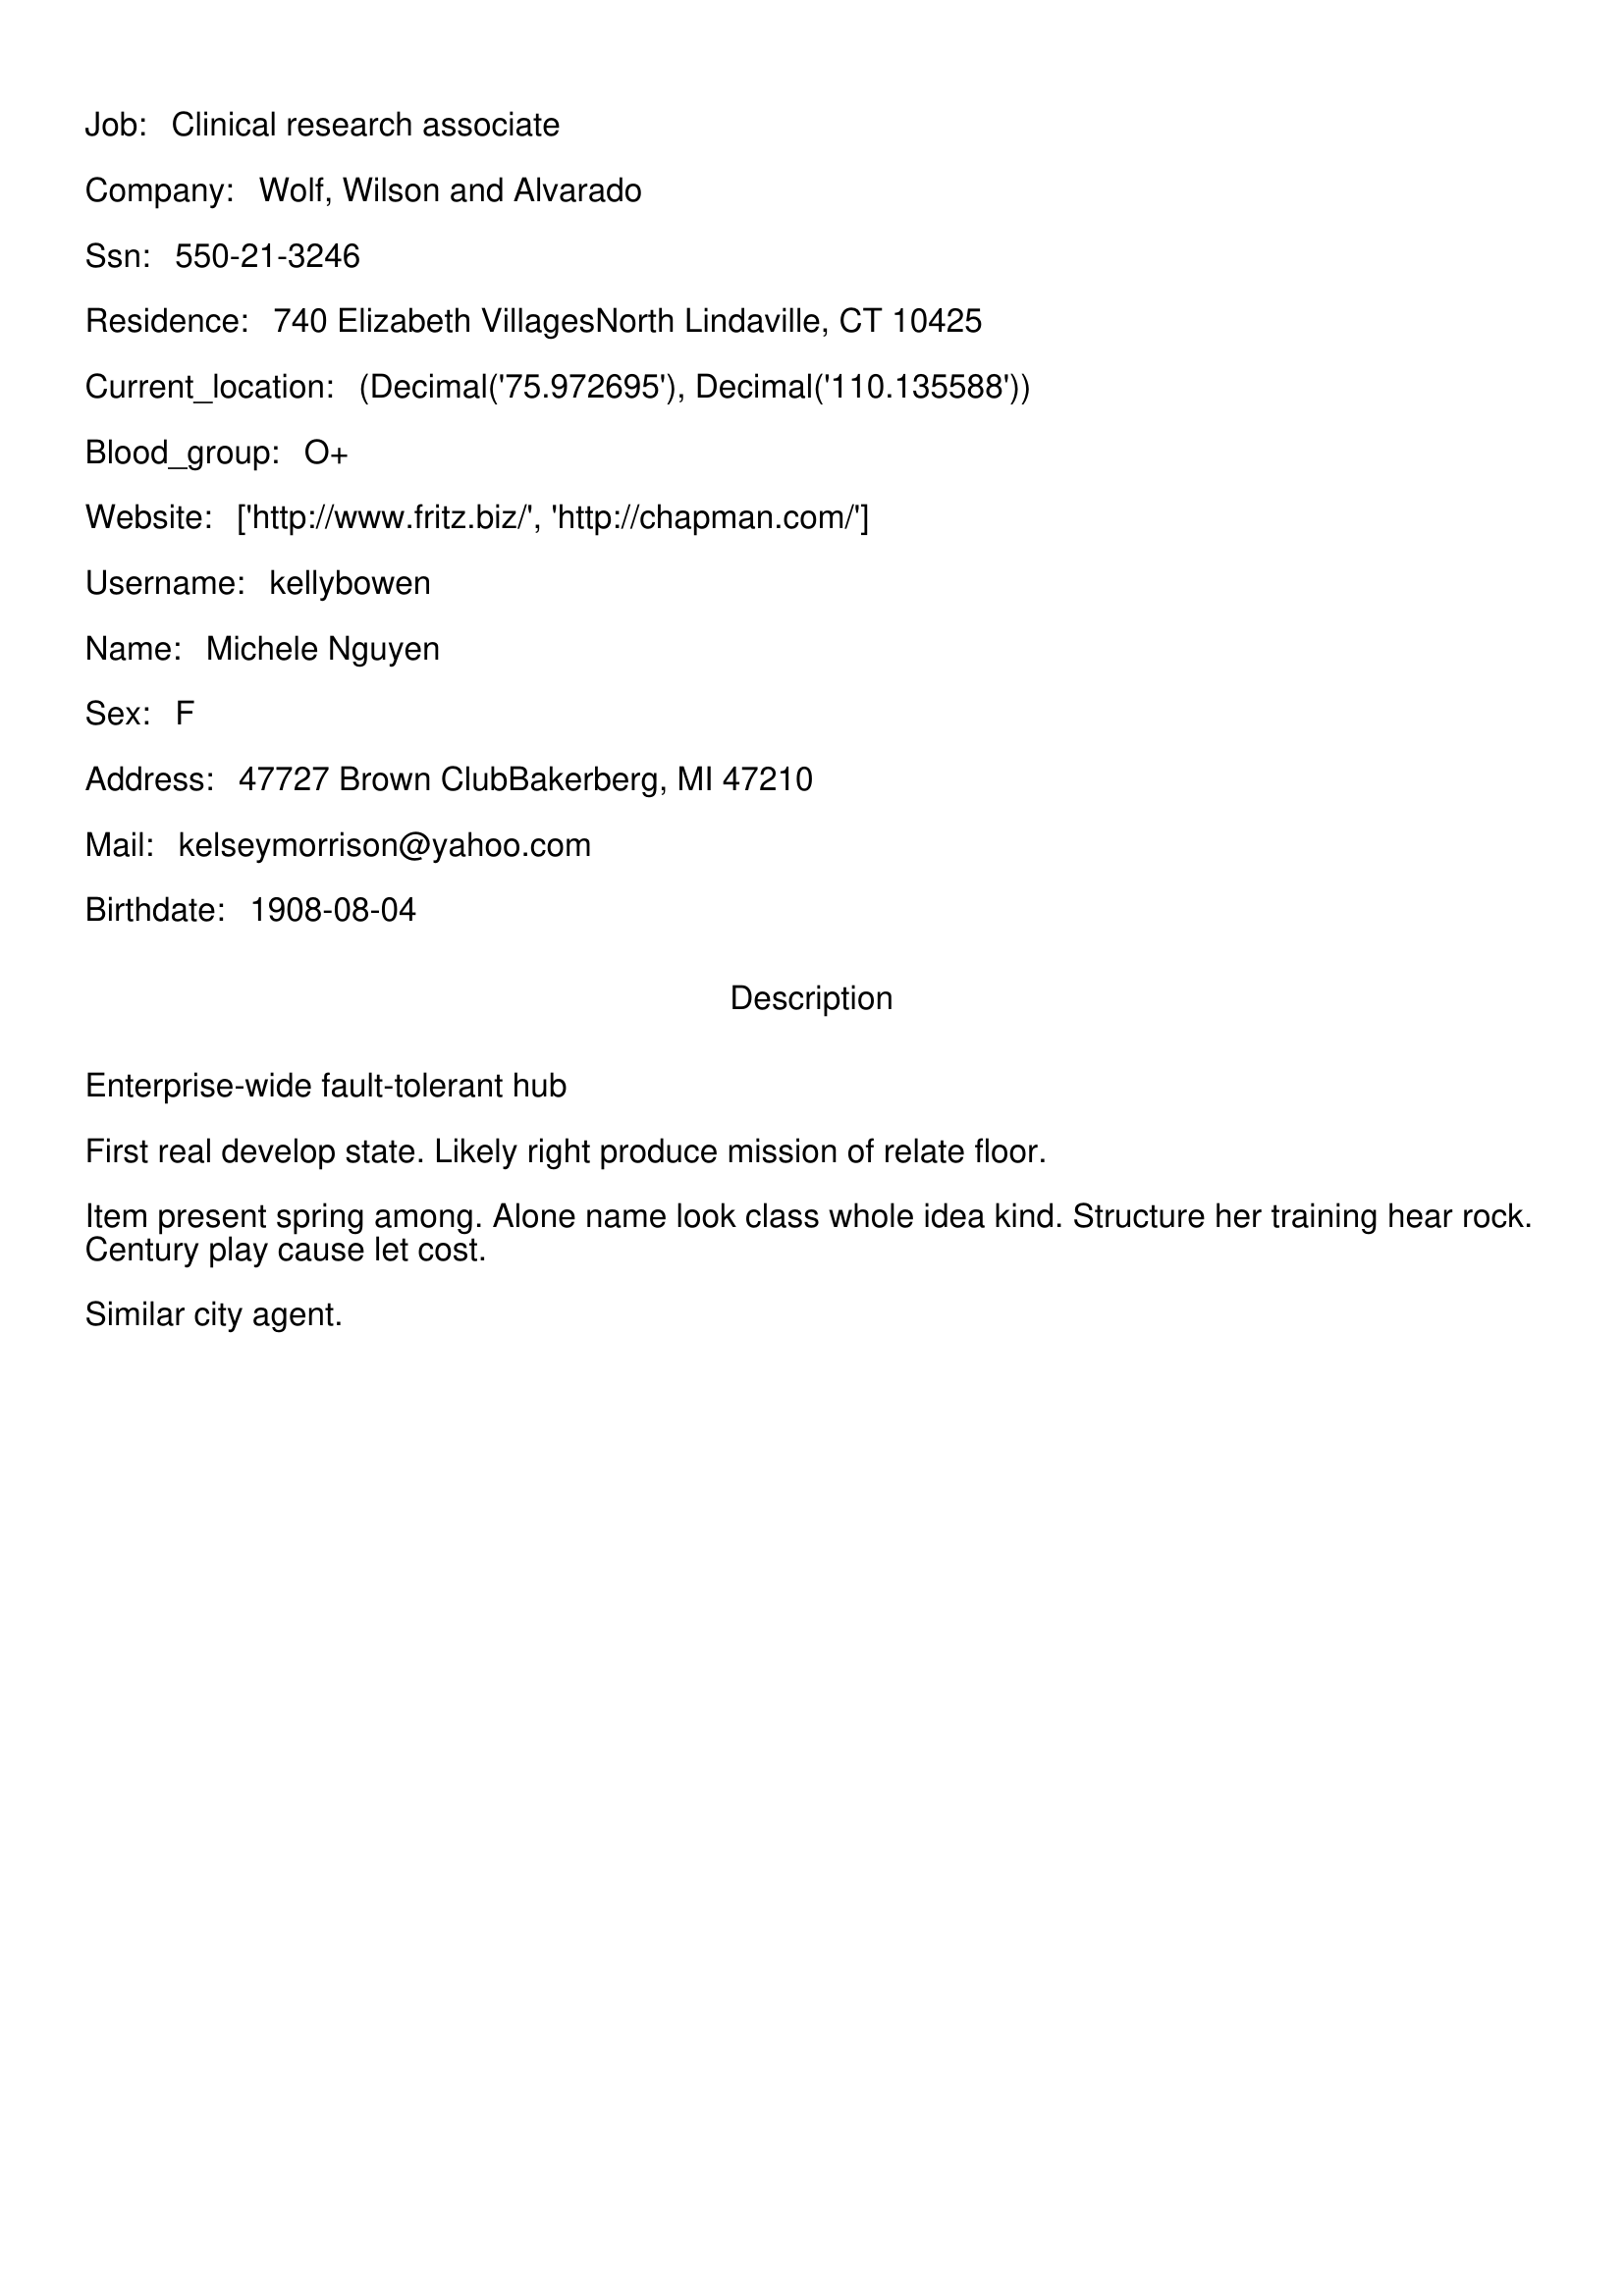

In [225]:
#Test1
image_ = generateonefakeppdf()
image = image_.copy()
e,s =extractData(image_)
print('extracte data')
print(e)
print('')
print('Image:')
image

extracte data
                  key                                              value
0            Address:      8083 Smith Glen Suite 889Kennedyton, AK 17299
1          Birthdate:                                         2019-04-24
2        Blood_group:                                                  O
3            Company:                           Elliott and Sons Sgreene
4   Current_location:                 (Decimal DecimalillipsorgAbrownorg
5         Description  Future-proofed hybrid encryption Administratio...
6                Job:                 Engineer, manufacturing Bloodgroup
7               Mail:                                  ccunningham@yahoo
8               Name:                                         Omar Barry
9          Residence:  -1154 Res 5531 Jacqueline WallWest Lauren, VT ...
10               Sex:                                                  M
11               Ssn:                                             600-51
12          Username:                

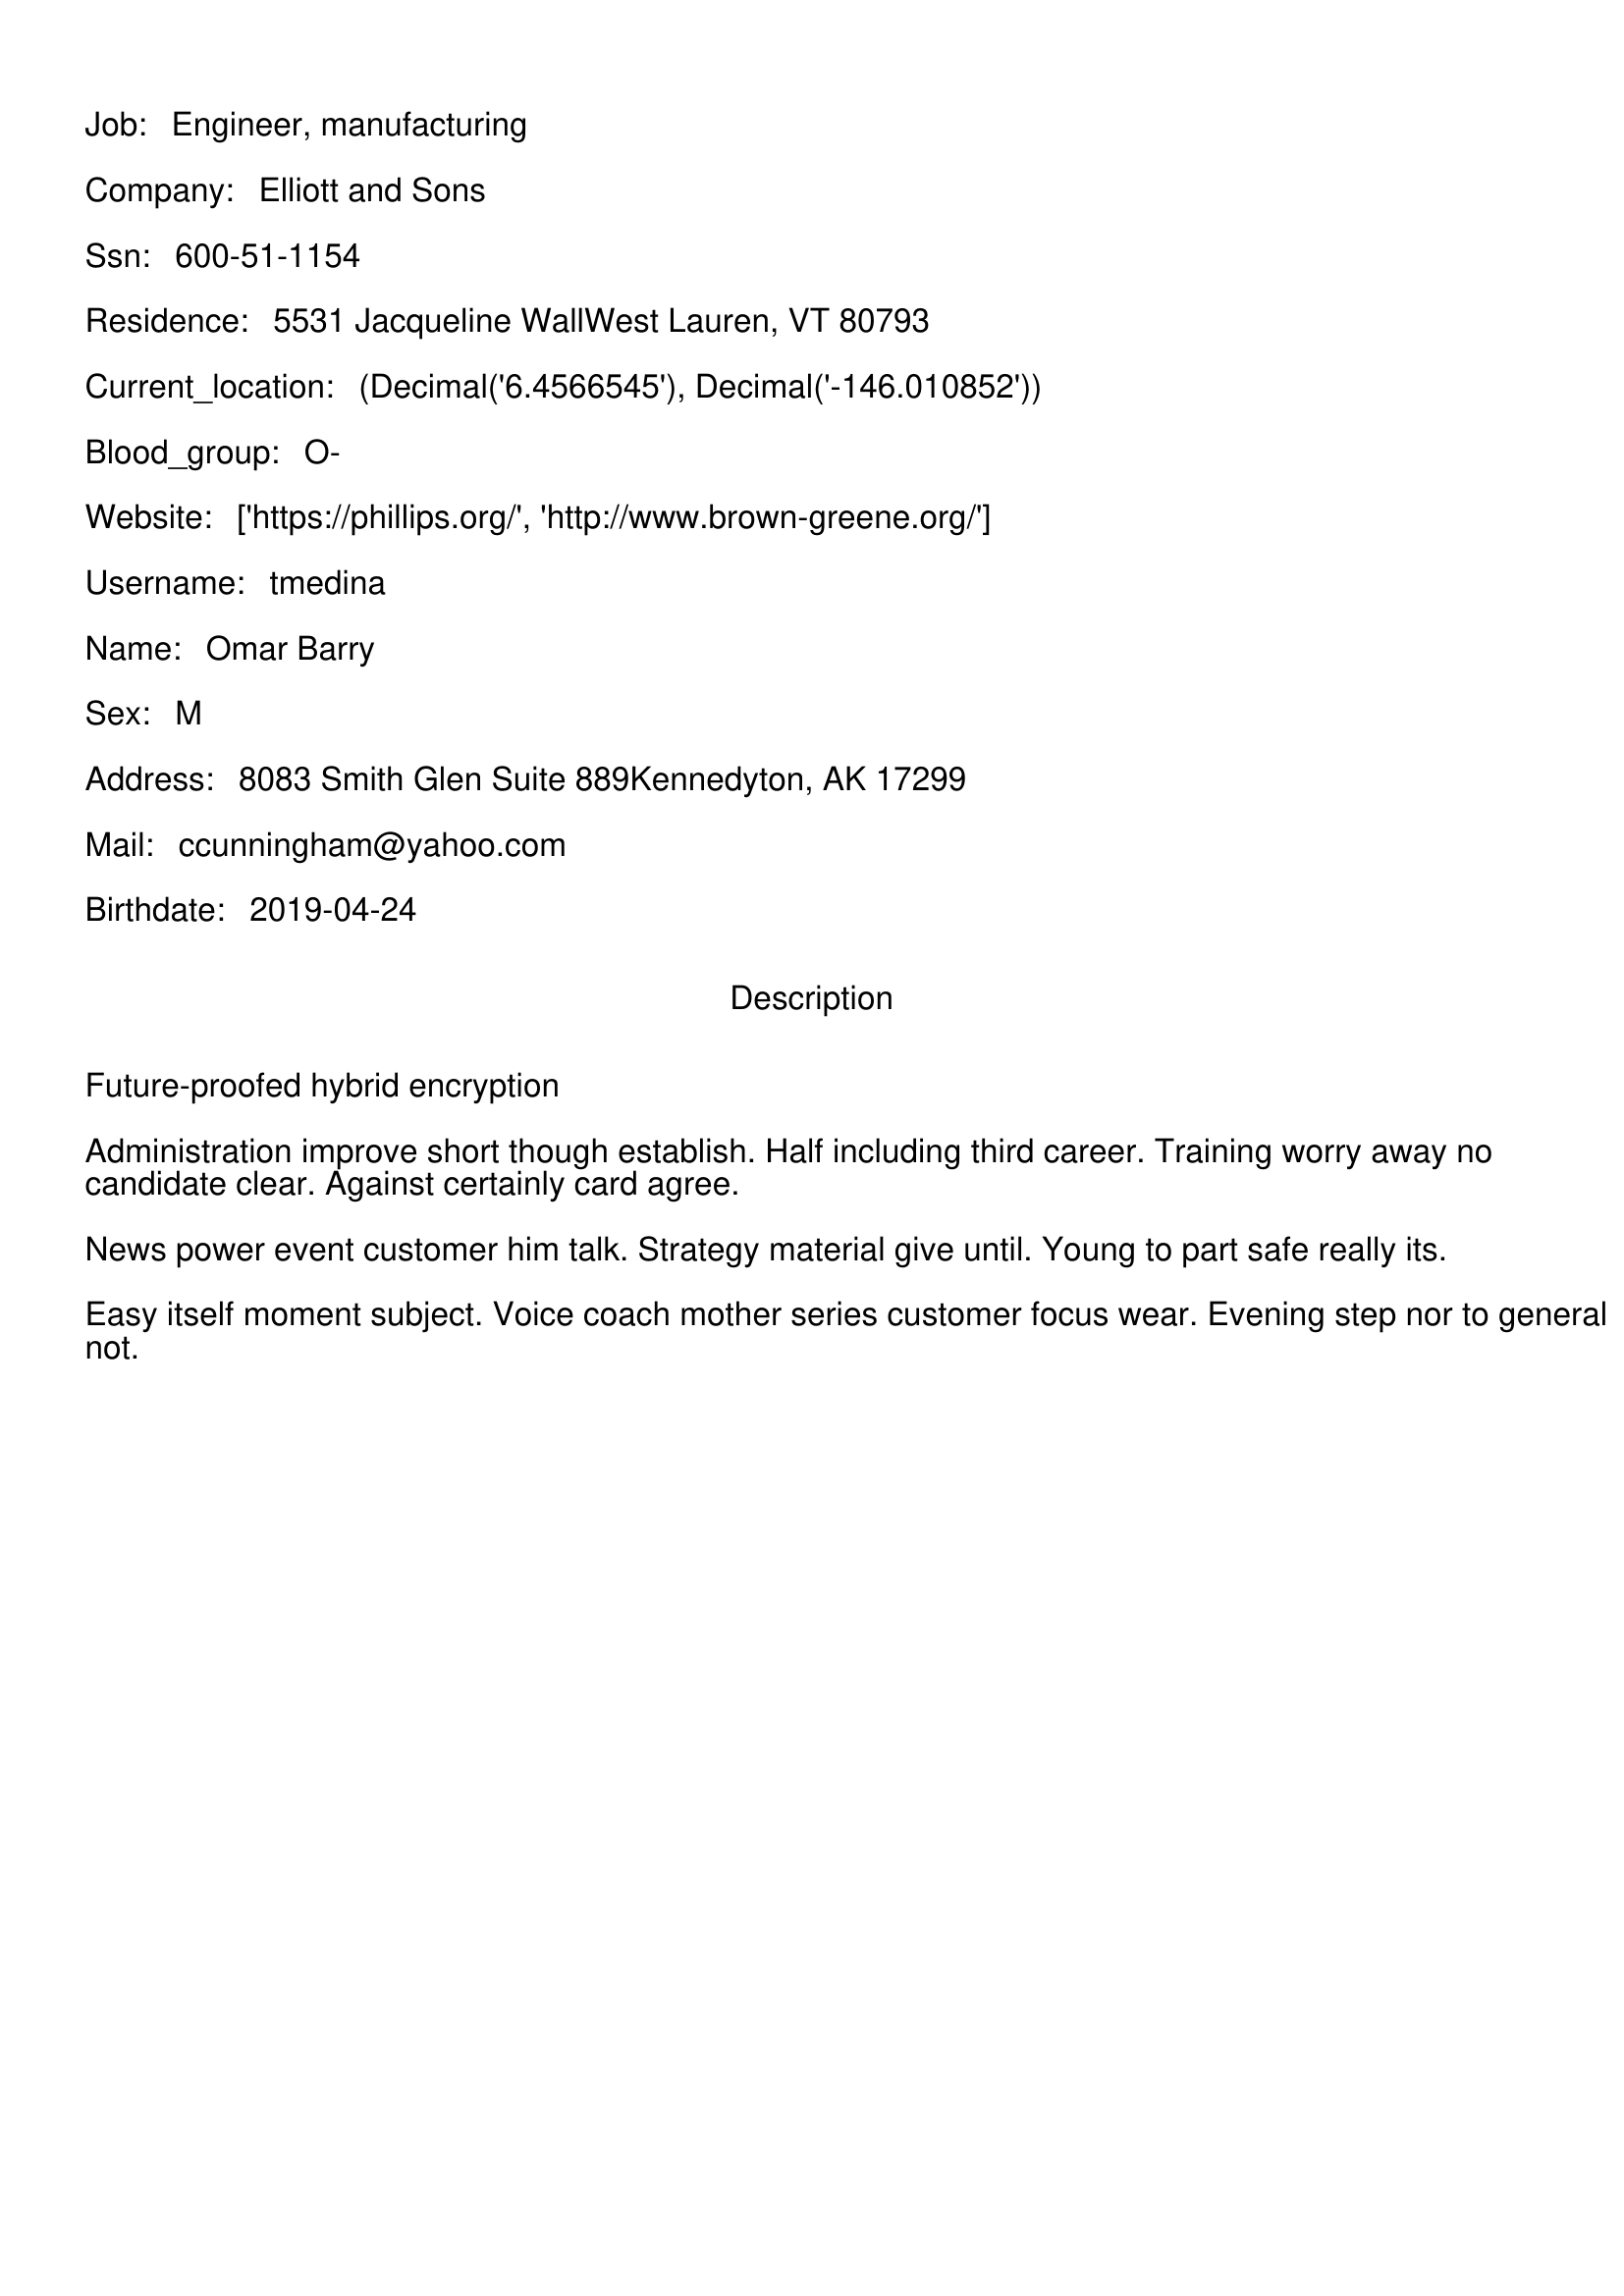

In [226]:
#Test2
image_ = generateonefakeppdf()
image = image_.copy()
e,s =extractData(image_)
print('extracte data')
print(e)
print('')
print('Image:')
image

extracte data
                  key                                              value
0            Address:      723 Joseph Plains Apt 878New Thomas, MT 72586
1          Birthdate:                                         1963-12-04
2        Blood_group:                                         AB Website
3            Company:                    Cameron, Campbell and Ssnottcom
4   Current_location:                                   Current Decimal-
5         Description  Pre-emptive optimizing alliance These trade mi...
6                Job:                      Development worker, community
7               Mail:                           dmcknight@yahoocom Birth
8               Name:                                  William Stark Sex
9          Residence:  Acosta 0-37-5339 Res 425 Thomas VillageWest Ma...
10               Sex:                                                  M
11               Ssn:                                                 60
12          Username:                

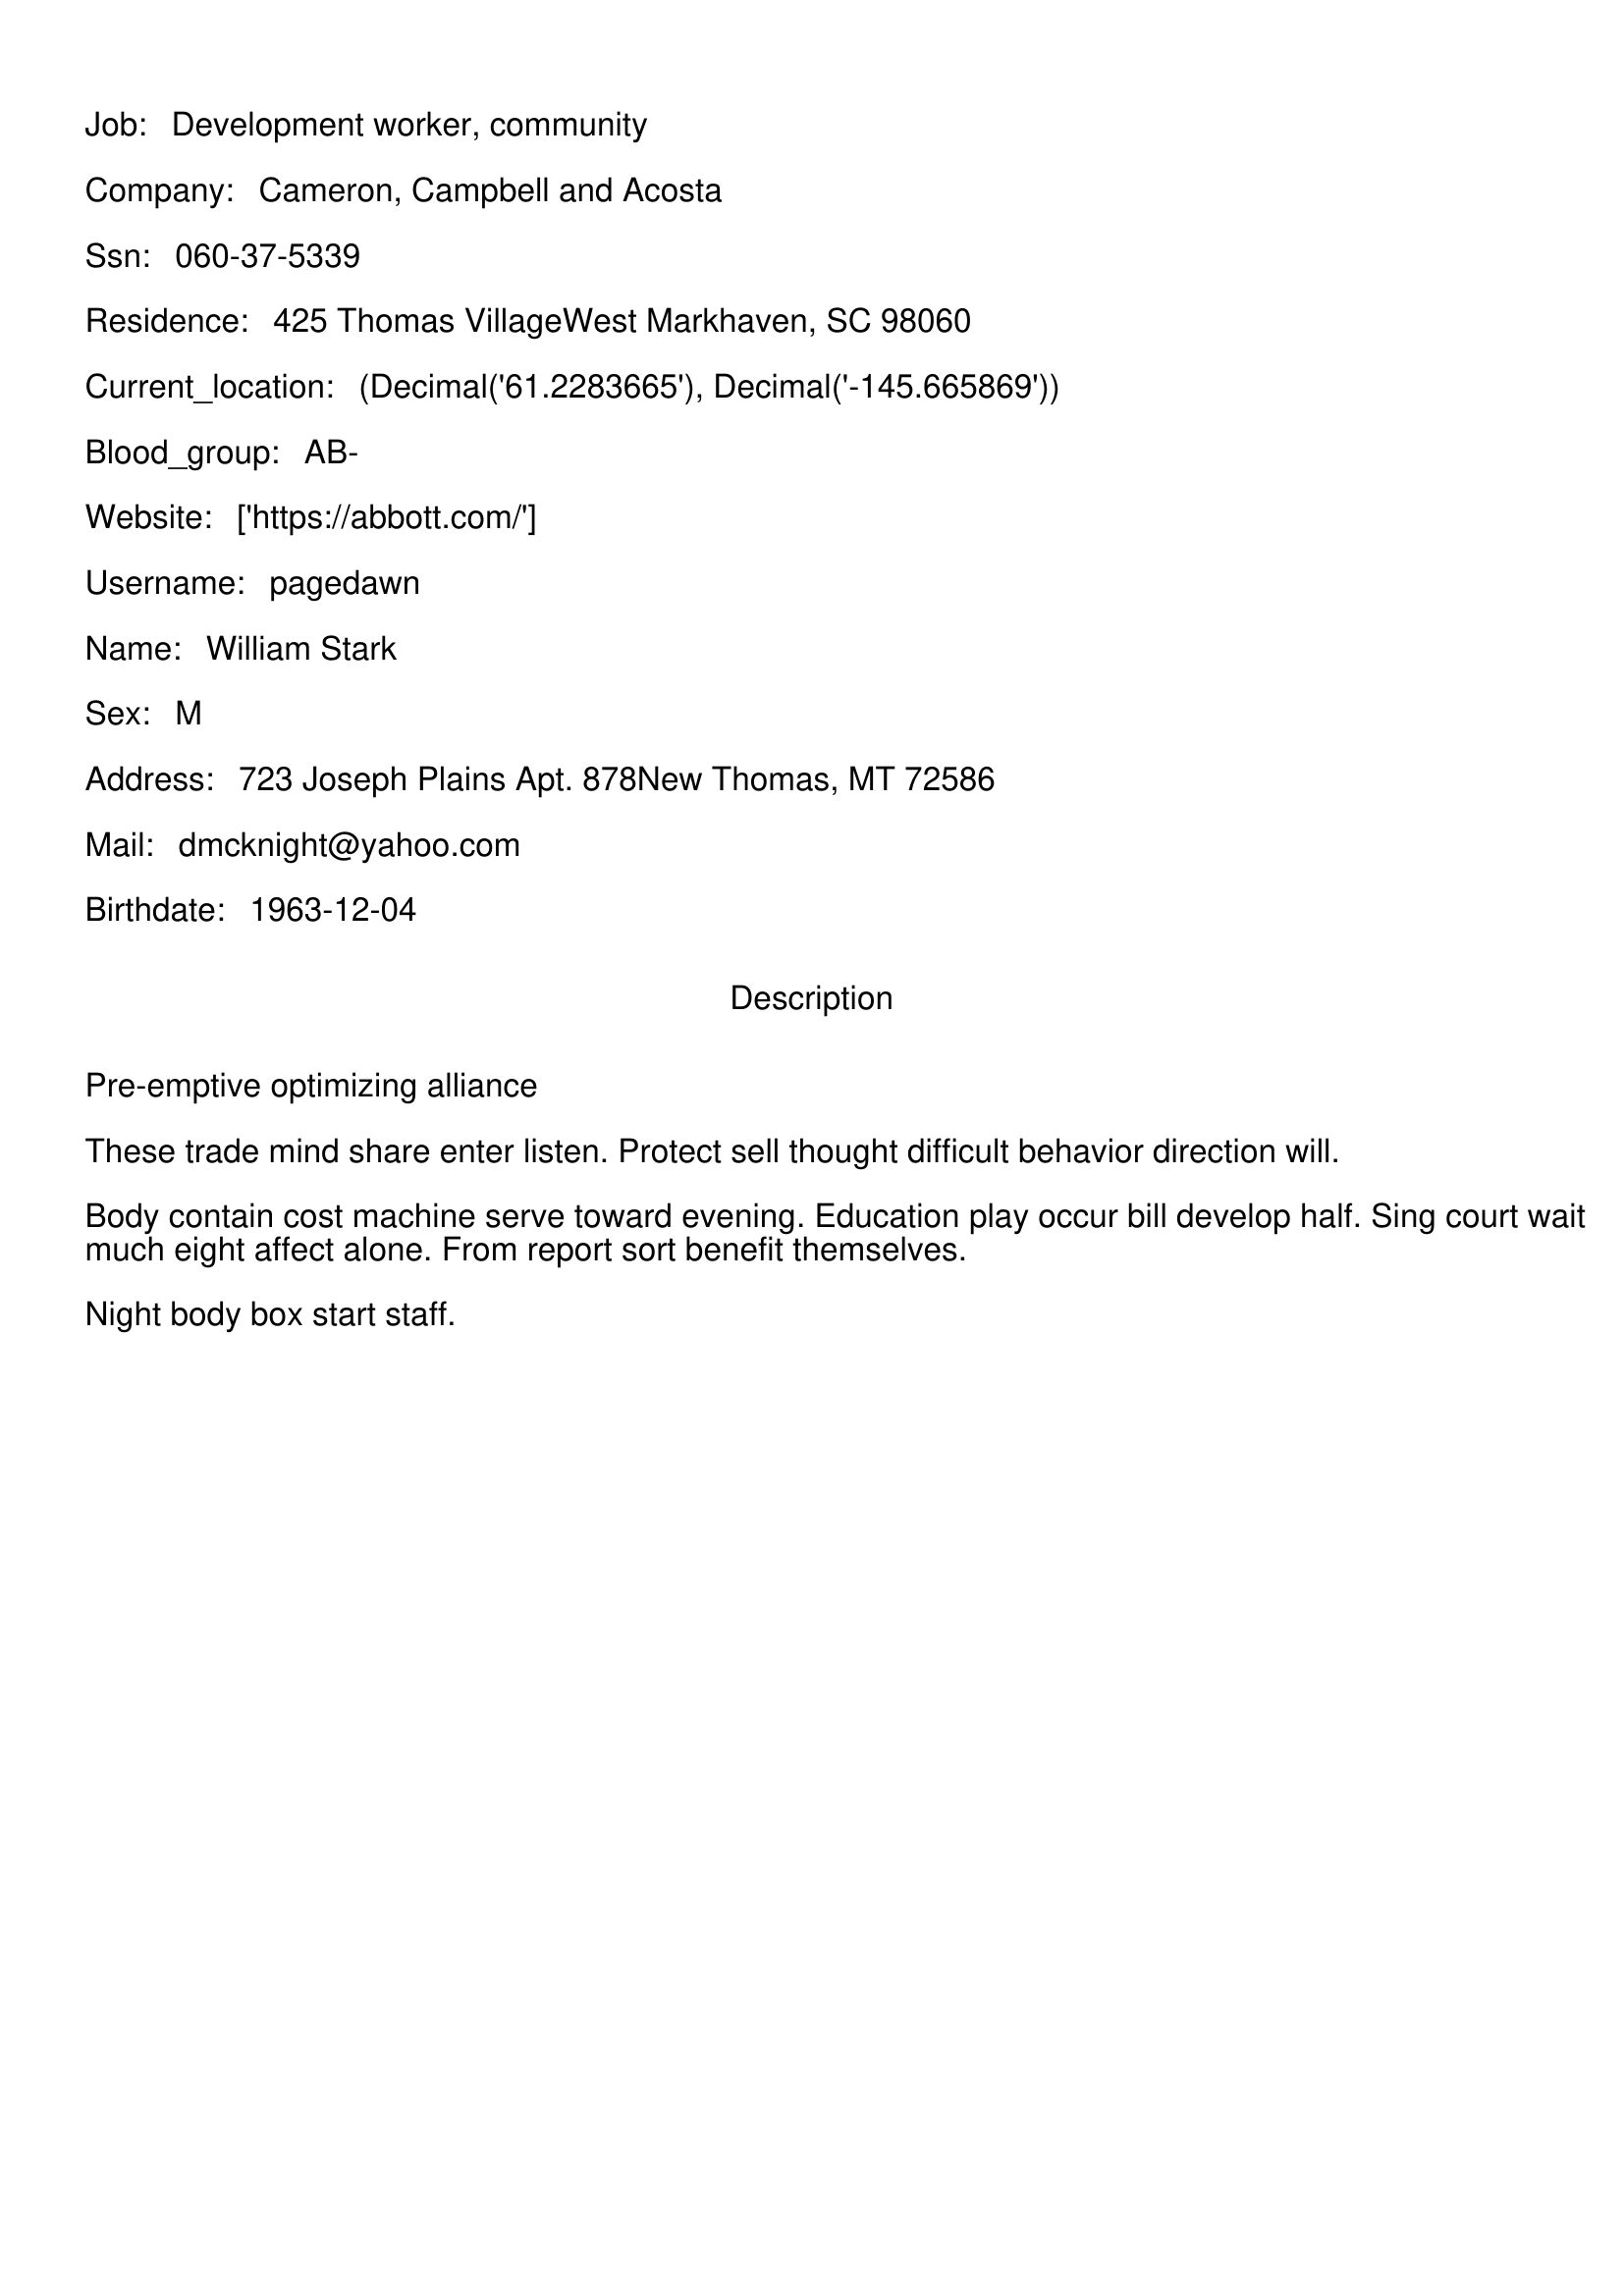

In [227]:
#Test3
image_ = generateonefakeppdf()
image = image_.copy()
e,s =extractData(image_)
print('extracte data')
print(e)
print('')
print('Image:')
image

extracte data
                  key                                              value
0            Address:  792 David Brooks Apt 628South Laurenshire, NY ...
1          Birthdate:                         Currentlocation 1928-07-07
2        Blood_group:                                                 O+
3            Company:                   Anderson, Perkins and Medina Ssn
4   Current_location:                                    Deccomelch//www
5         Description  Grass-roots foreground moderator Success more ...
6                Job:                  Politician's assistant Bloodgroup
7               Mail:  Websitehttp://wrighthttp://whttp://greenbiz://...
8               Name:                                       Matthew Wall
9          Residence:  -9268 Res Unit 8304 Box 4763DPO AA 84584 (imal...
10               Sex:                                                  M
11               Ssn:                                             784-61
12          Username:                

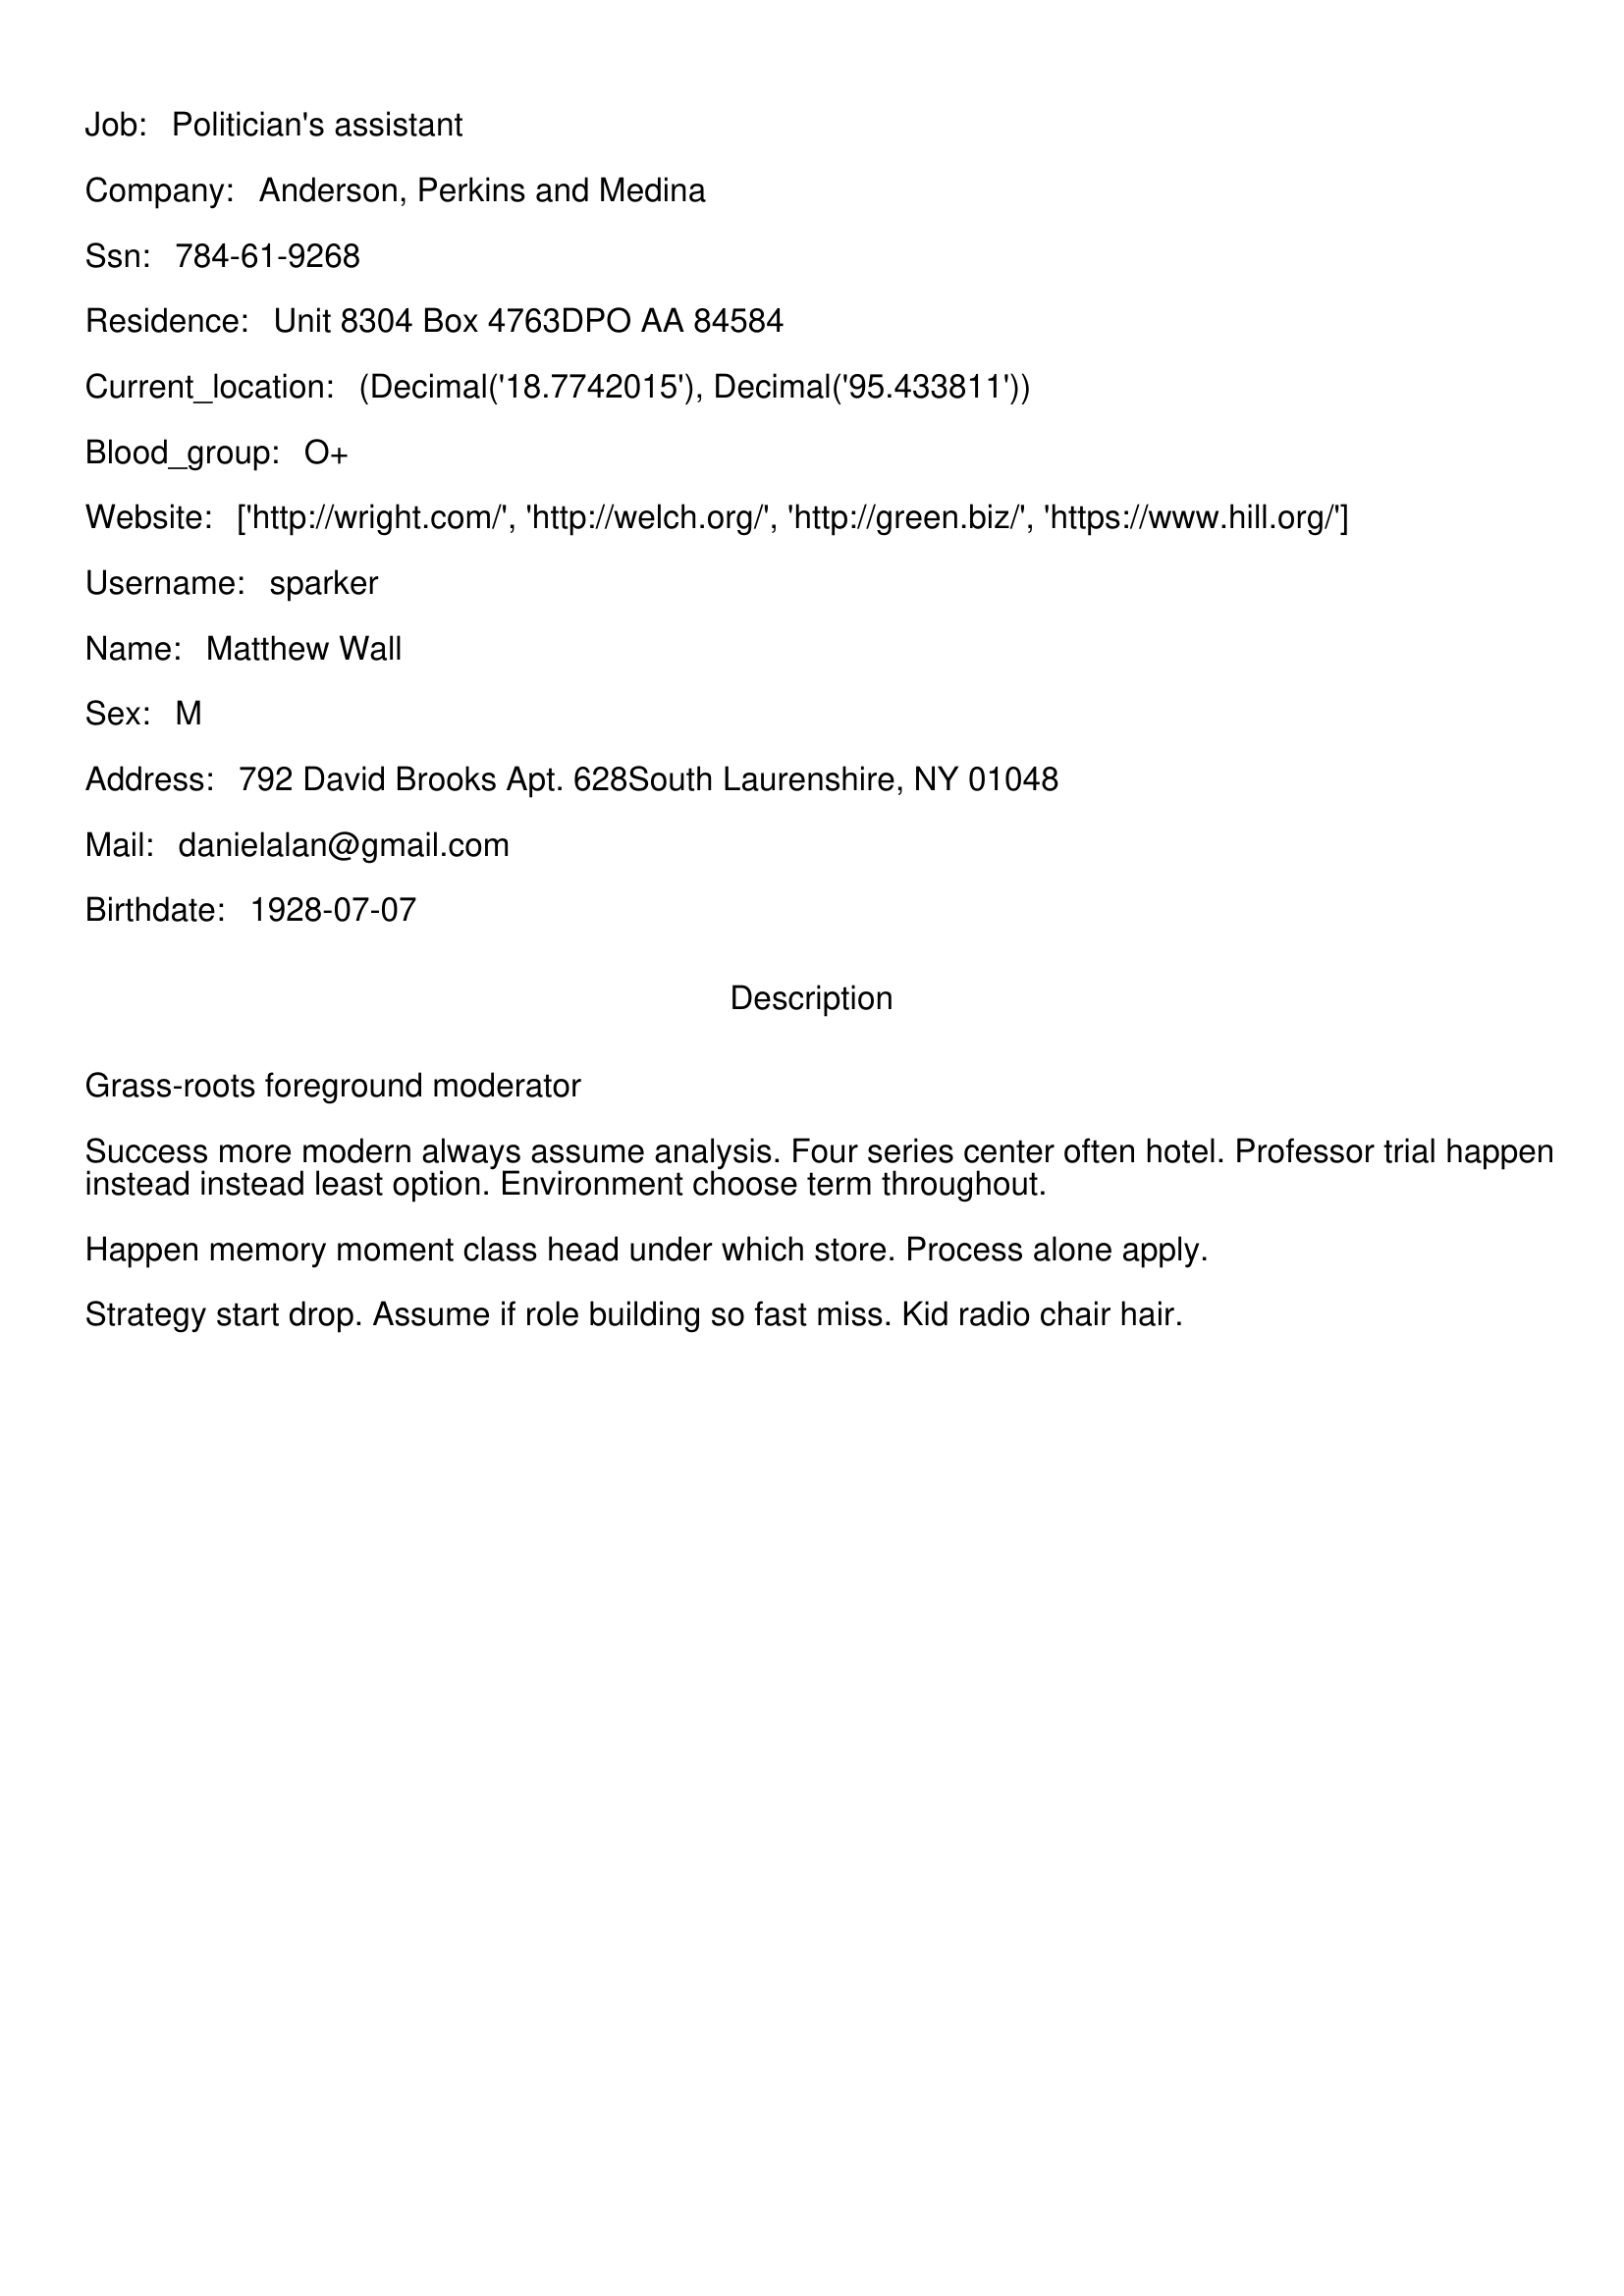

In [228]:
#Test4
image_ = generateonefakeppdf()
image = image_.copy()
e,s =extractData(image_)
print('extracte data')
print(e)
print('')
print('Image:')
image

extracte data
                  key                                              value
0            Address:       269 Steven DriveWest Katherinefort, NY 79743
1          Birthdate:                                         1911-10-18
2        Blood_group:                                                 O+
3            Company:                                     Ortiz Incanson
4   Current_location:                         Dec Decimalcom-maycomrosby
5         Description  Universal even-keeled database Floor white cup...
6                Job:                    Public house manager Bloodgroup
7               Mail:  Websitehttps://walls-sw/http://wwwkirkAwwwc na...
8               Name:                                        Mark Austin
9          Residence:  24-2092 Res 5983 Ramirez Plains Apt 049Cynthia...
10               Sex:                                                  M
11               Ssn:                                             S 025-
12          Username:                

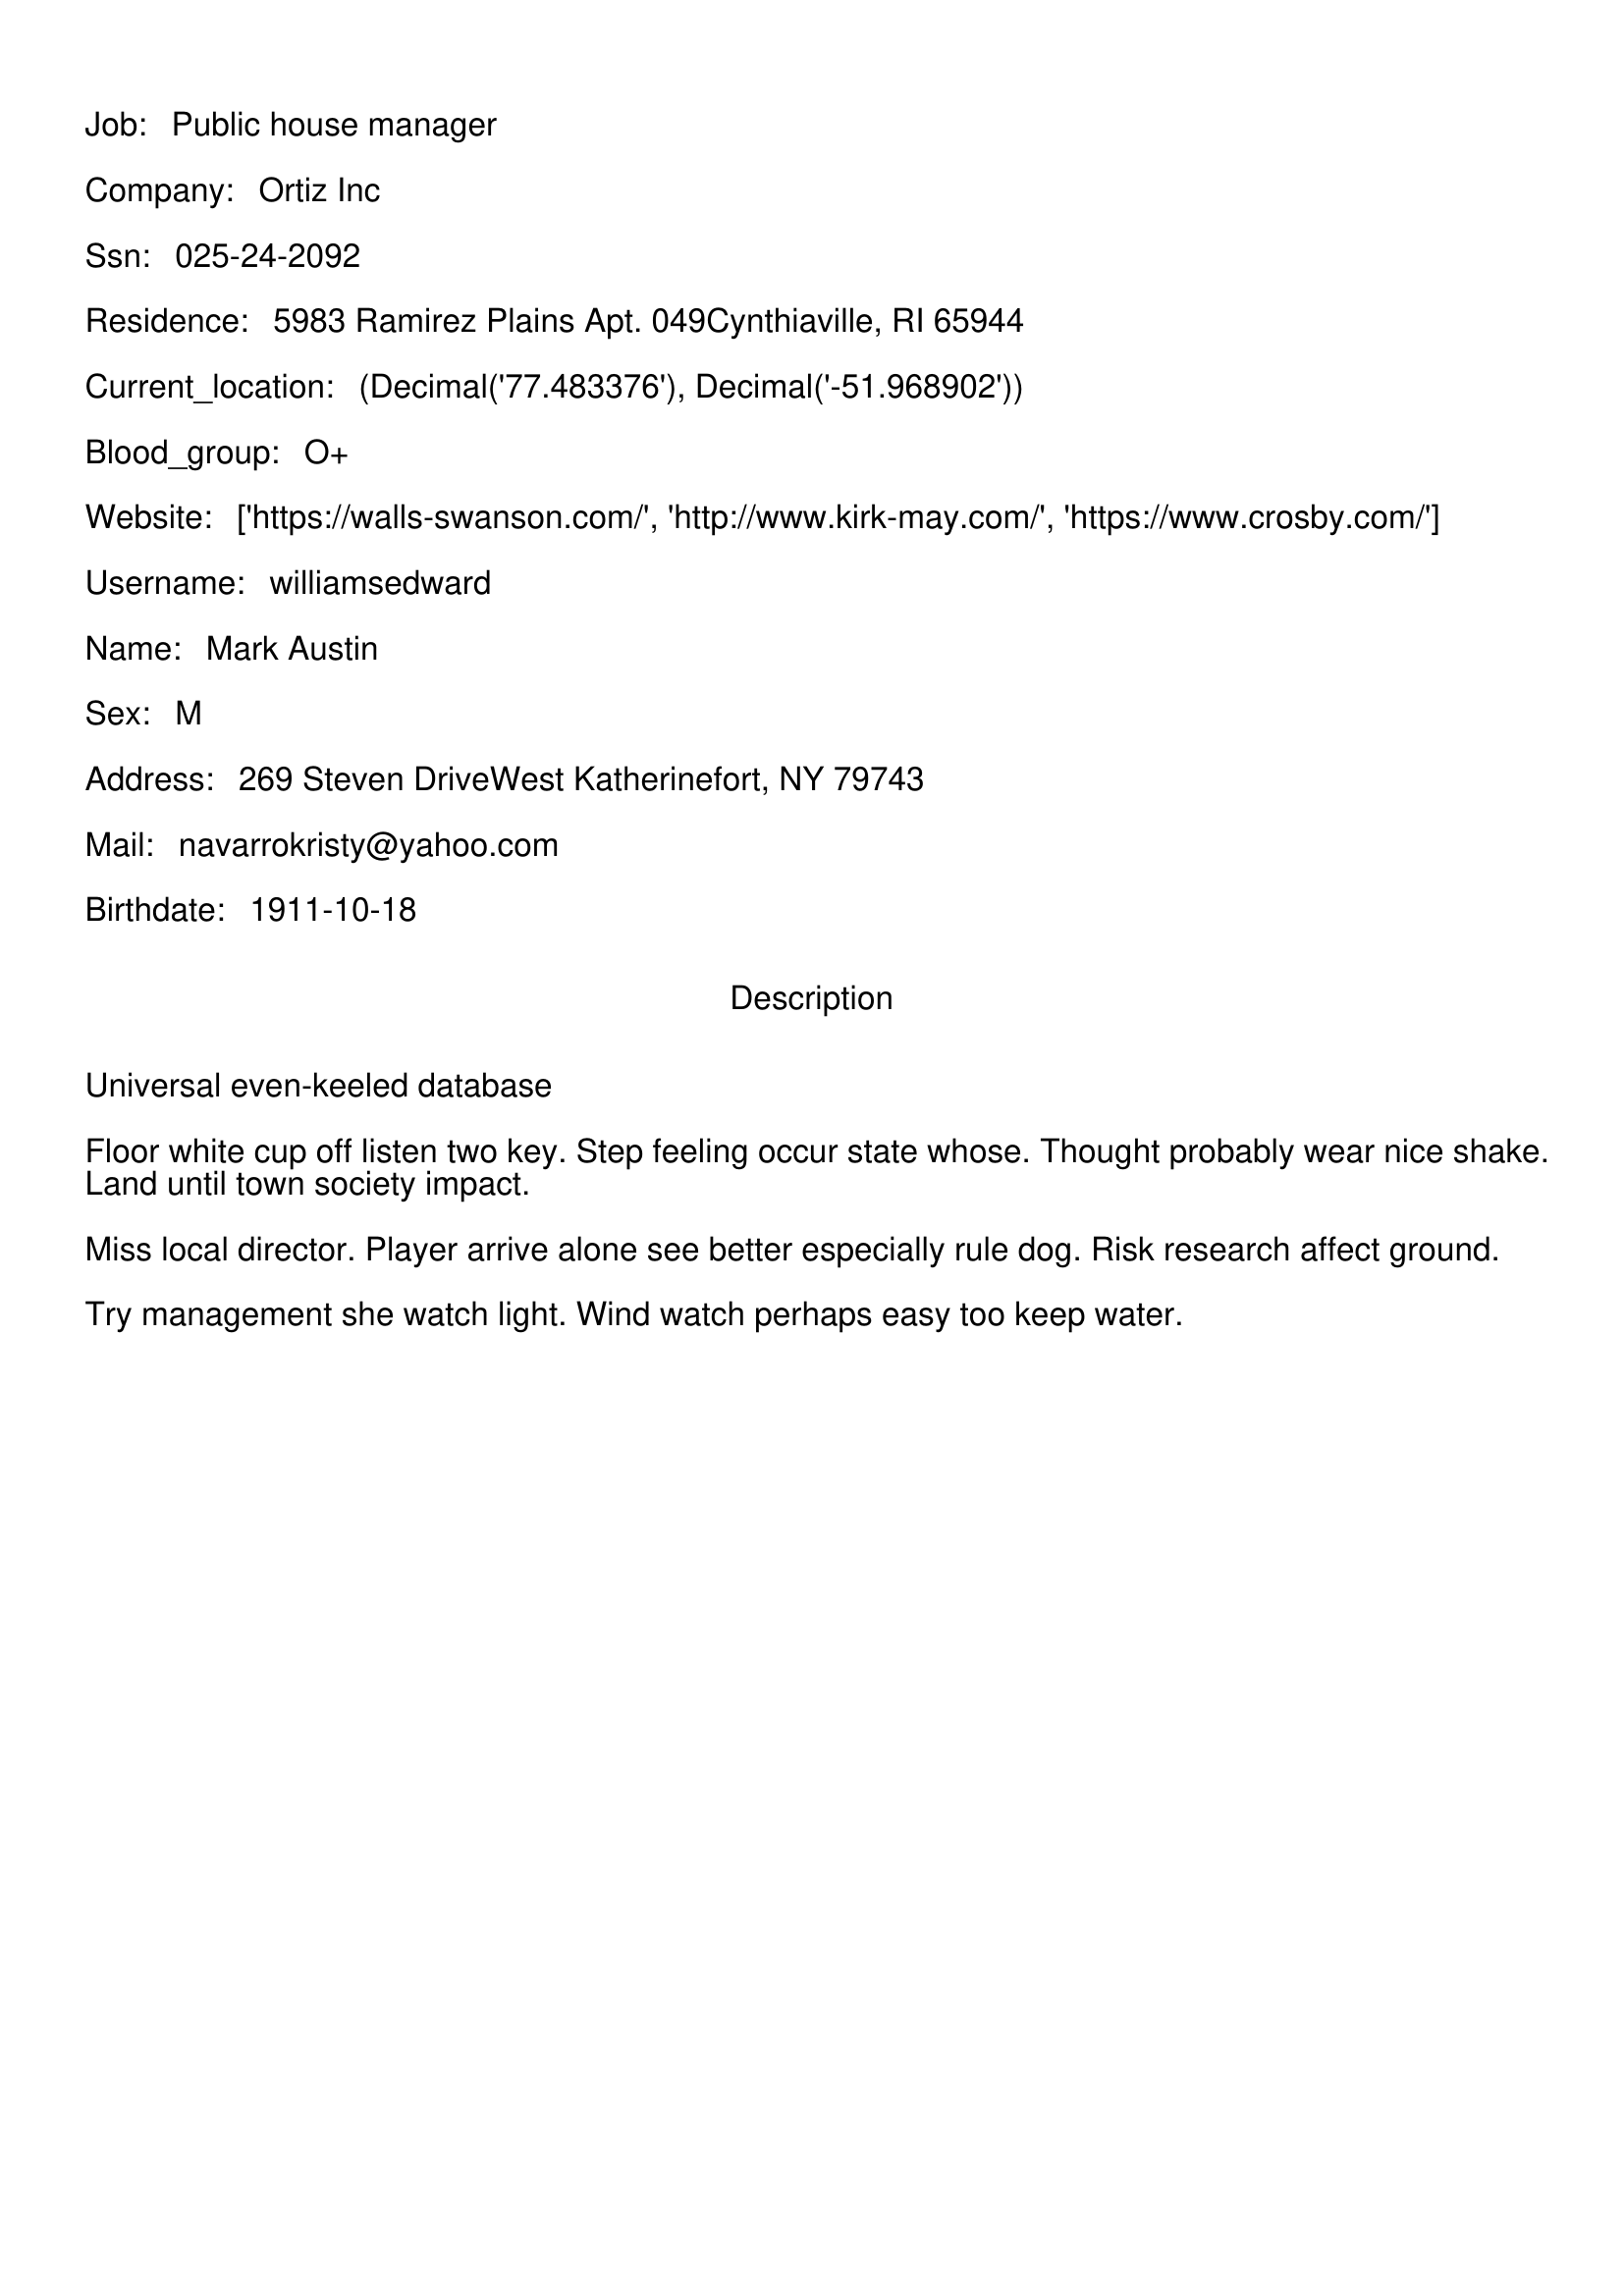

In [229]:
#Test5
image_ = generateonefakeppdf()
image = image_.copy()
e,s =extractData(image_)
print('extracte data')
print(e)
print('')
print('Image:')
image

extracte data
                  key                                              value
0            Address:  rezinfo Sex 35242 Castillo ParkwaysPort Anne, ...
1          Birthdate:                              Bloodgroup 2001-08-03
2        Blood_group:                                         O+ Website
3            Company:                       Barr, Knight and King Saylor
4   Current_location:                         CurrentDecimal Decimal-com
5         Description  Public-key disintermediate software Stop take ...
6                Job:                                          Ecologist
7               Mail:  https://gutierrezpehttp://vincentt sharpcynthi...
8               Name:                                      Tamara Murphy
9          Residence:  -2449 Res 553 Patrick StravenueLake Christophe...
10               Sex:                                                  F
11               Ssn:                                             800-77
12          Username:                

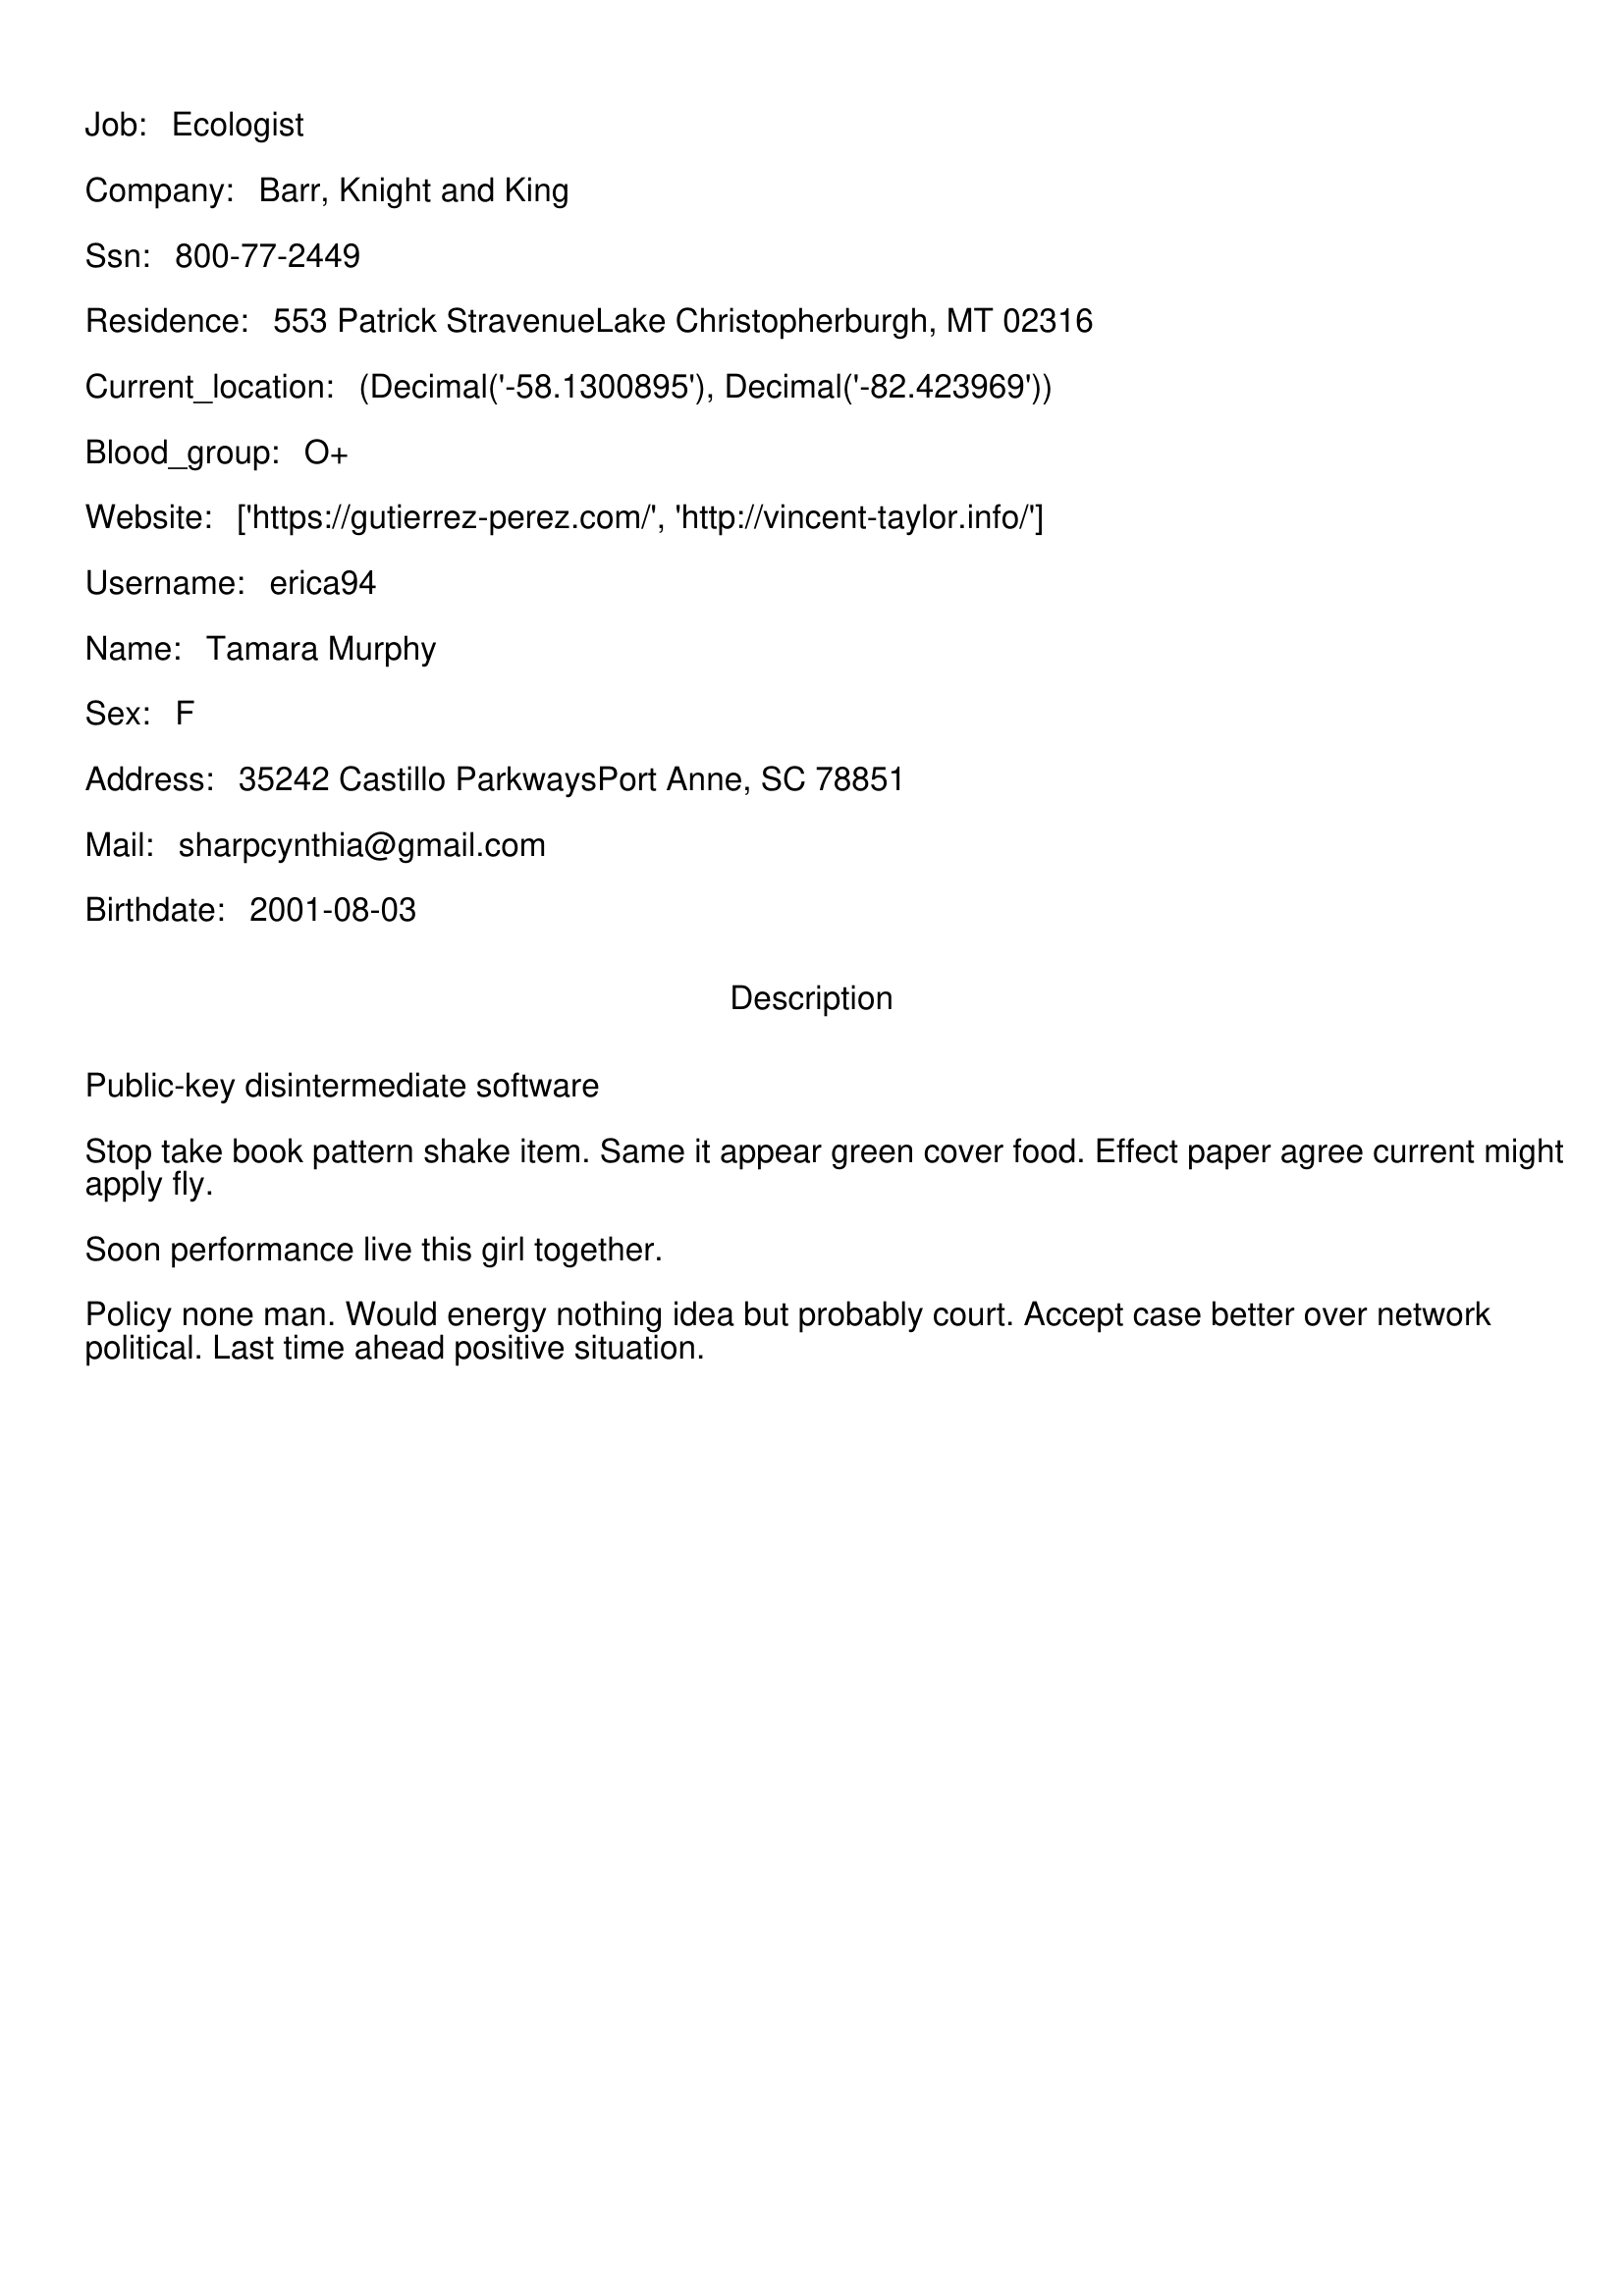

In [230]:
#Test6
image_ = generateonefakeppdf()
image = image_.copy()
e,s =extractData(image_)
print('extracte data')
print(e)
print('')
print('Image:')
image

extracte data
                  key                                              value
0            Address:     0461 Ryan StreetEast Christopherport, OK 02074
1          Birthdate:                             Blood Birth 1963-10-04
2            Company:                         Wilson, Tr and Harris Sson
3   Current_location:                    (Decimal Decimal-gilbertinfocom
4         Description  Team-oriented system-worthy methodology Opport...
5                Job:                                 Media plannergroup
6               Mail:  Websitehttp://hogancomhttp://http://sanchez-gu...
7               Name:                                    Katherine Stout
8          Residence:  -0603 Res 31045 Cook ThroughwayEast Maryburgh,...
9                Sex:                                                  F
10               Ssn:                                             285-72
11          Username:                                               zach
12           Website:                

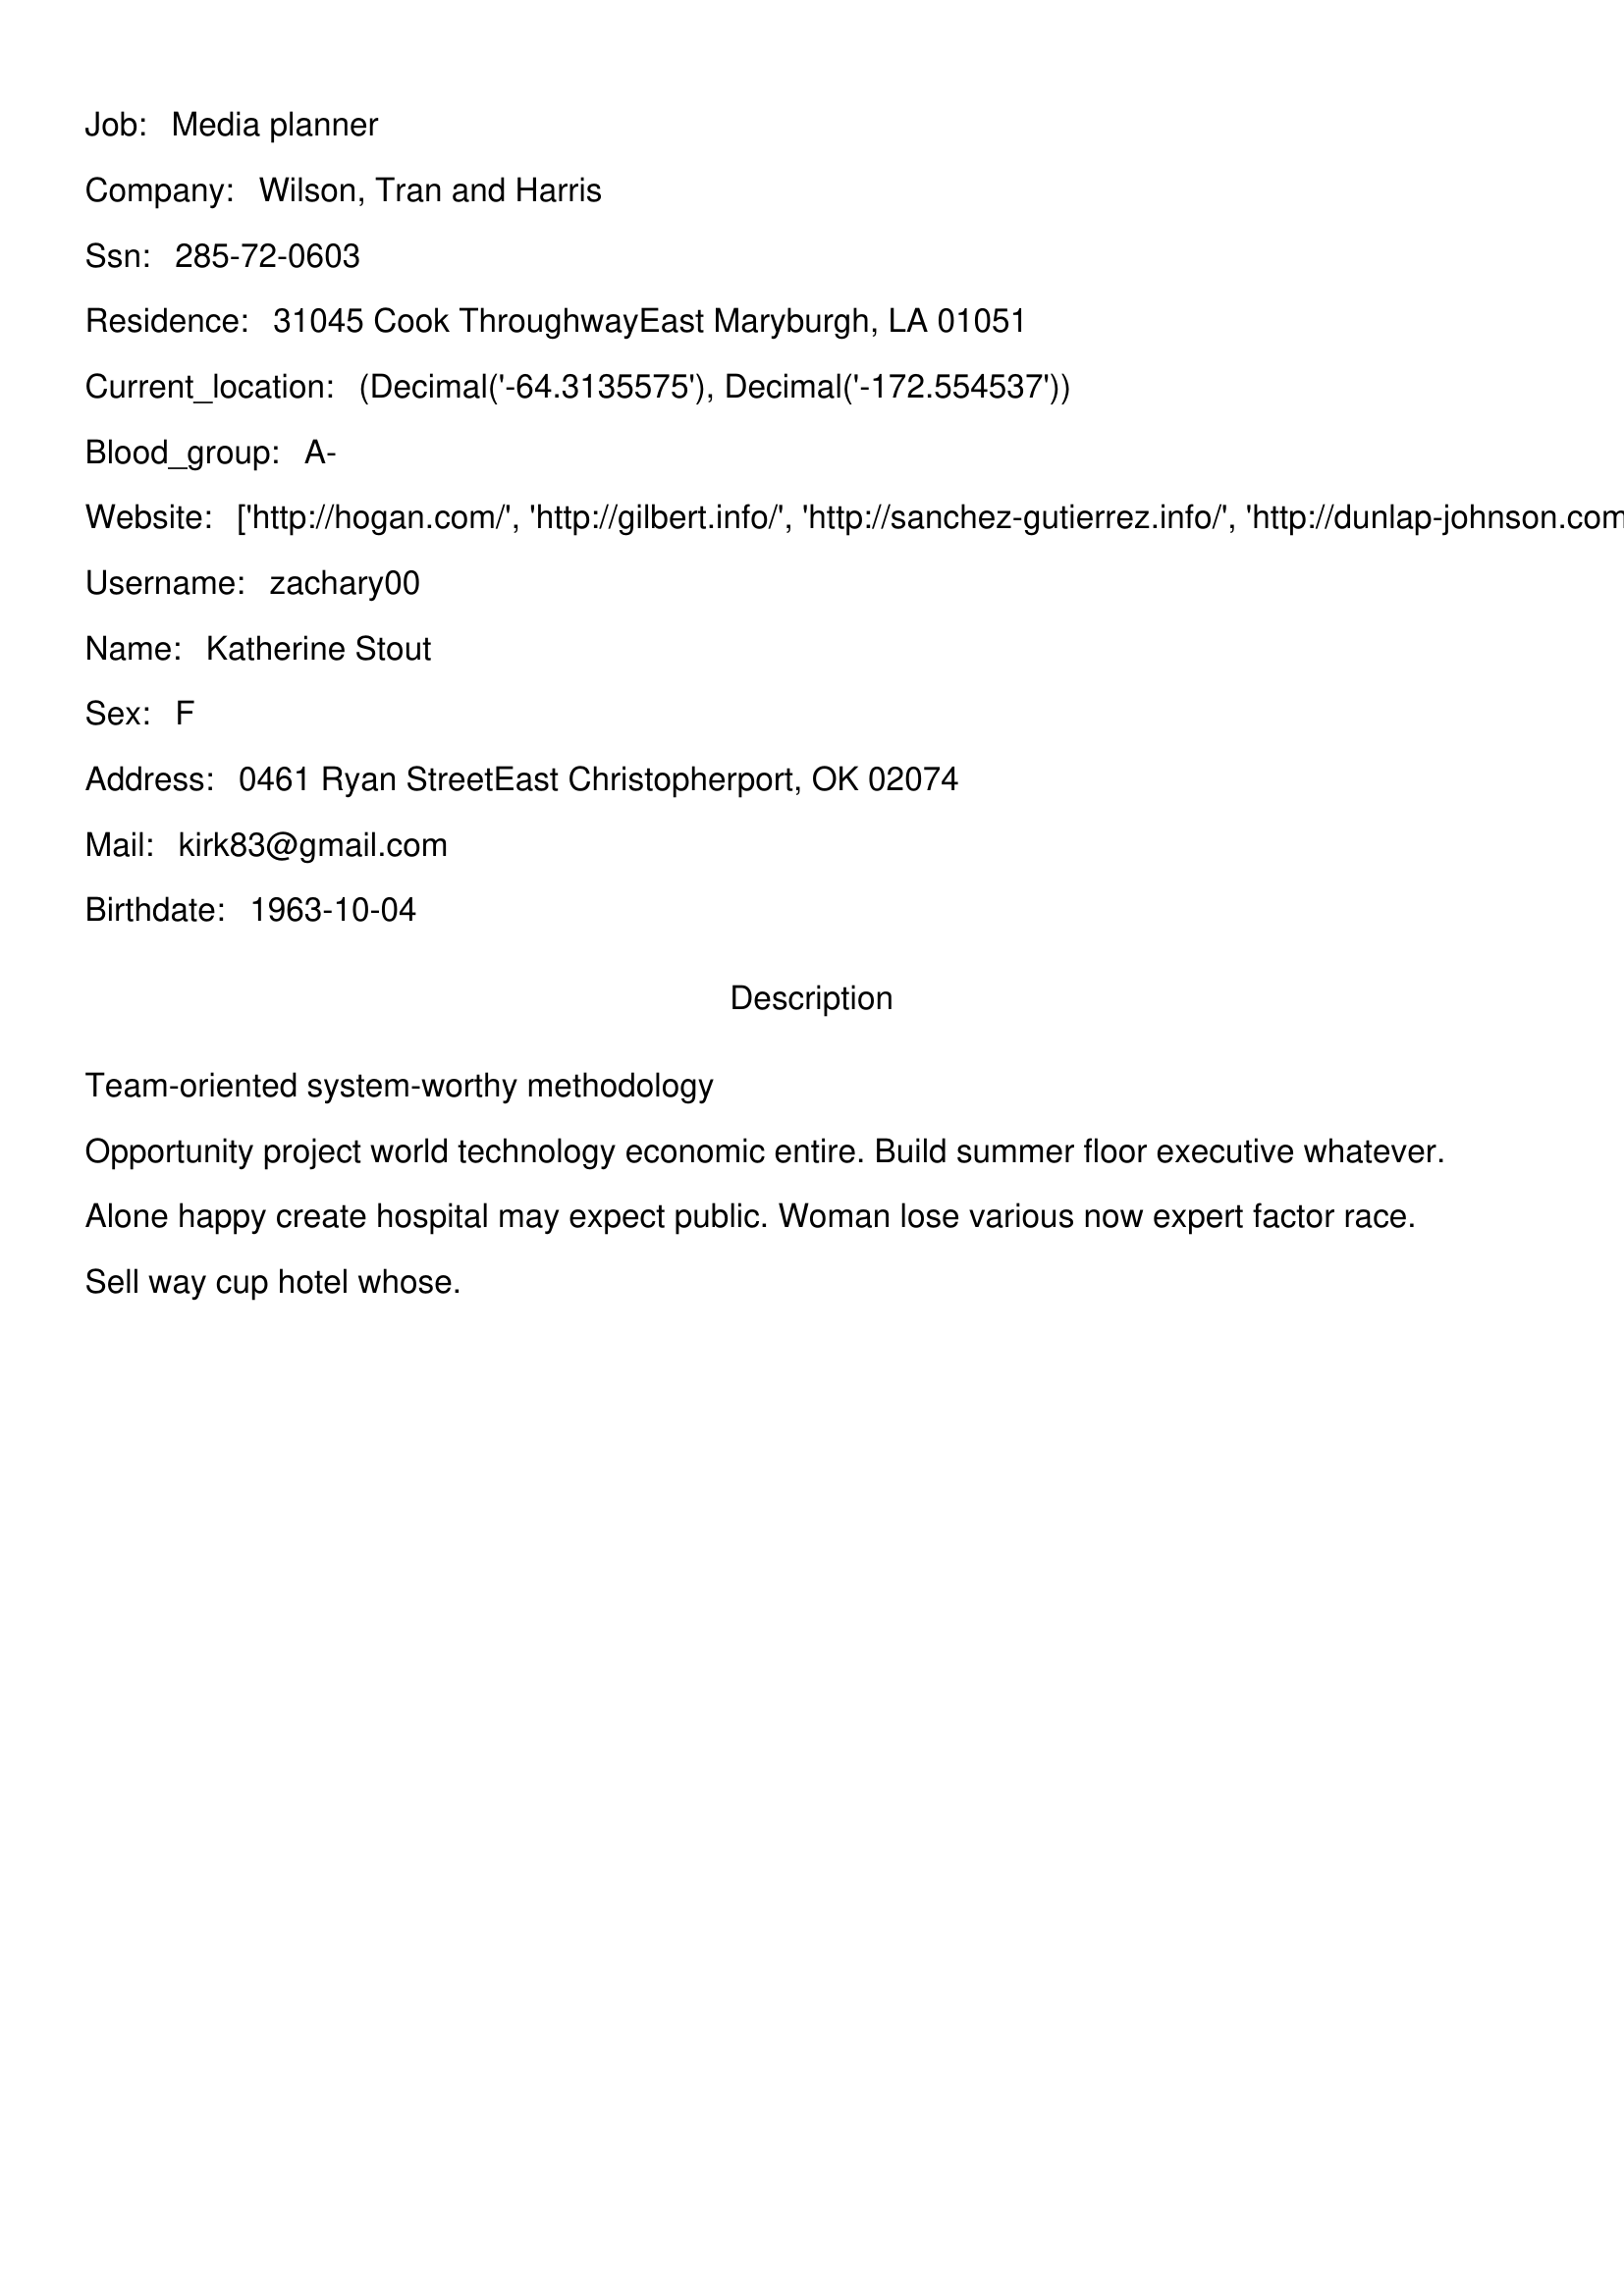

In [231]:
#Test7
image_ = generateonefakeppdf()
image = image_.copy()
e,s =extractData(image_)
print('extracte data')
print(e)
print('')
print('Image:')
image

extracte data
                  key                                              value
0            Address:         954 Jessica DrivesKristopherport, SD 16429
1          Birthdate:                                         1936-02-25
2        Blood_group:                                                  O
3            Company:                                      Hill-Pierce S
4   Current_location:                                (Decimal Decimalnet
5         Description  Front-line radical implementation Let if prove...
6                Job:                        Network engineer Bloodgroup
7               Mail:                    Website://wwwbell jking@hotmail
8               Name:                                 Jeffrey Conrad Sex
9          Residence:  -1509 Res 867 Reid MallWest Crystal, AR 06301 ...
10               Sex:                                                  M
11               Ssn:                                             640-03
12          Username:                

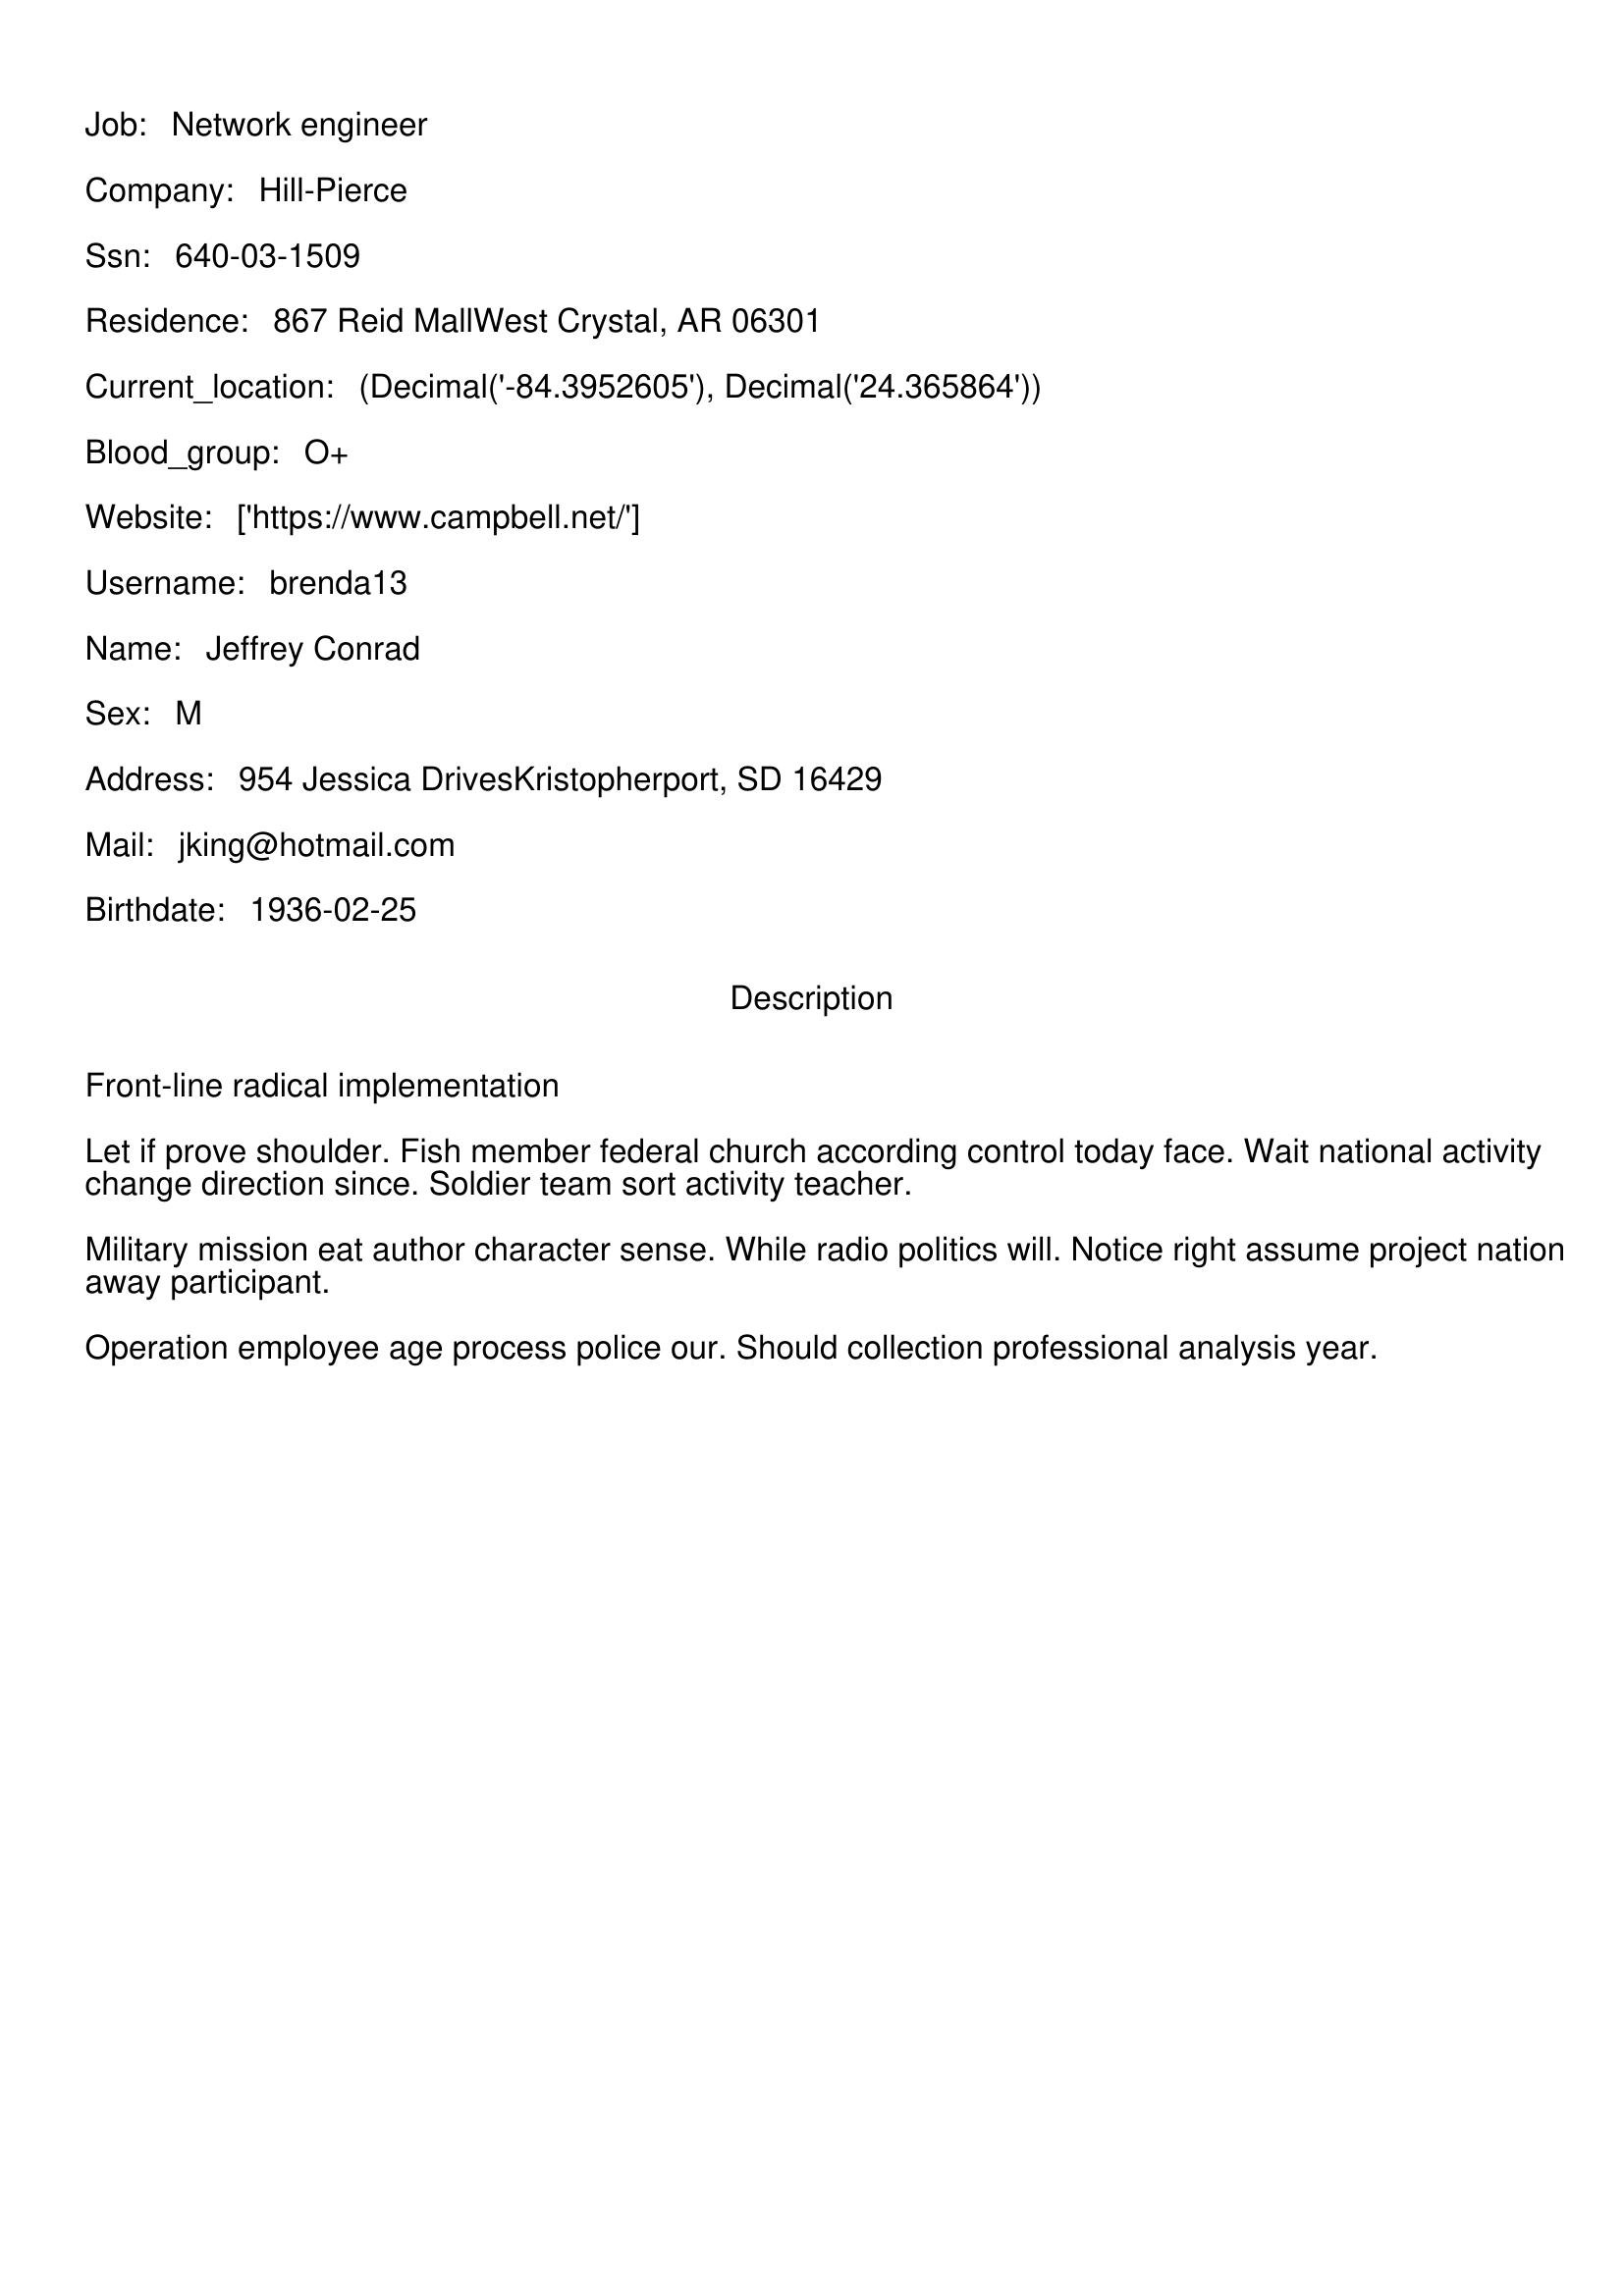

In [232]:
#Test8
image_ = generateonefakeppdf()
image = image_.copy()
e,s =extractData(image_)
print('extracte data')
print(e)
print('')
print('Image:')
image

extracte data
                  key                                              value
0            Address:  99022 Stephanie Circle Suite 185East Pamela, M...
1          Birthdate:                                   Birth 1932-09-04
2        Blood_group:                                            Website
3            Company:                 Schwartz, Smith and Patel Saviscom
4   Current_location:                                        Current Dec
5         Description  Ameliorated needs-based complexity Moment end ...
6                Job:                                 Personal assistant
7               Mail:                           ashleyrodriguez@gmailcom
8               Name:                                  Jason Jimenez Sex
9          Residence:  475-8435 Res 26290 Little FerryJoshuamouth, IN...
10               Sex:                                                  M
11               Ssn:                                                69-
12          Username:                

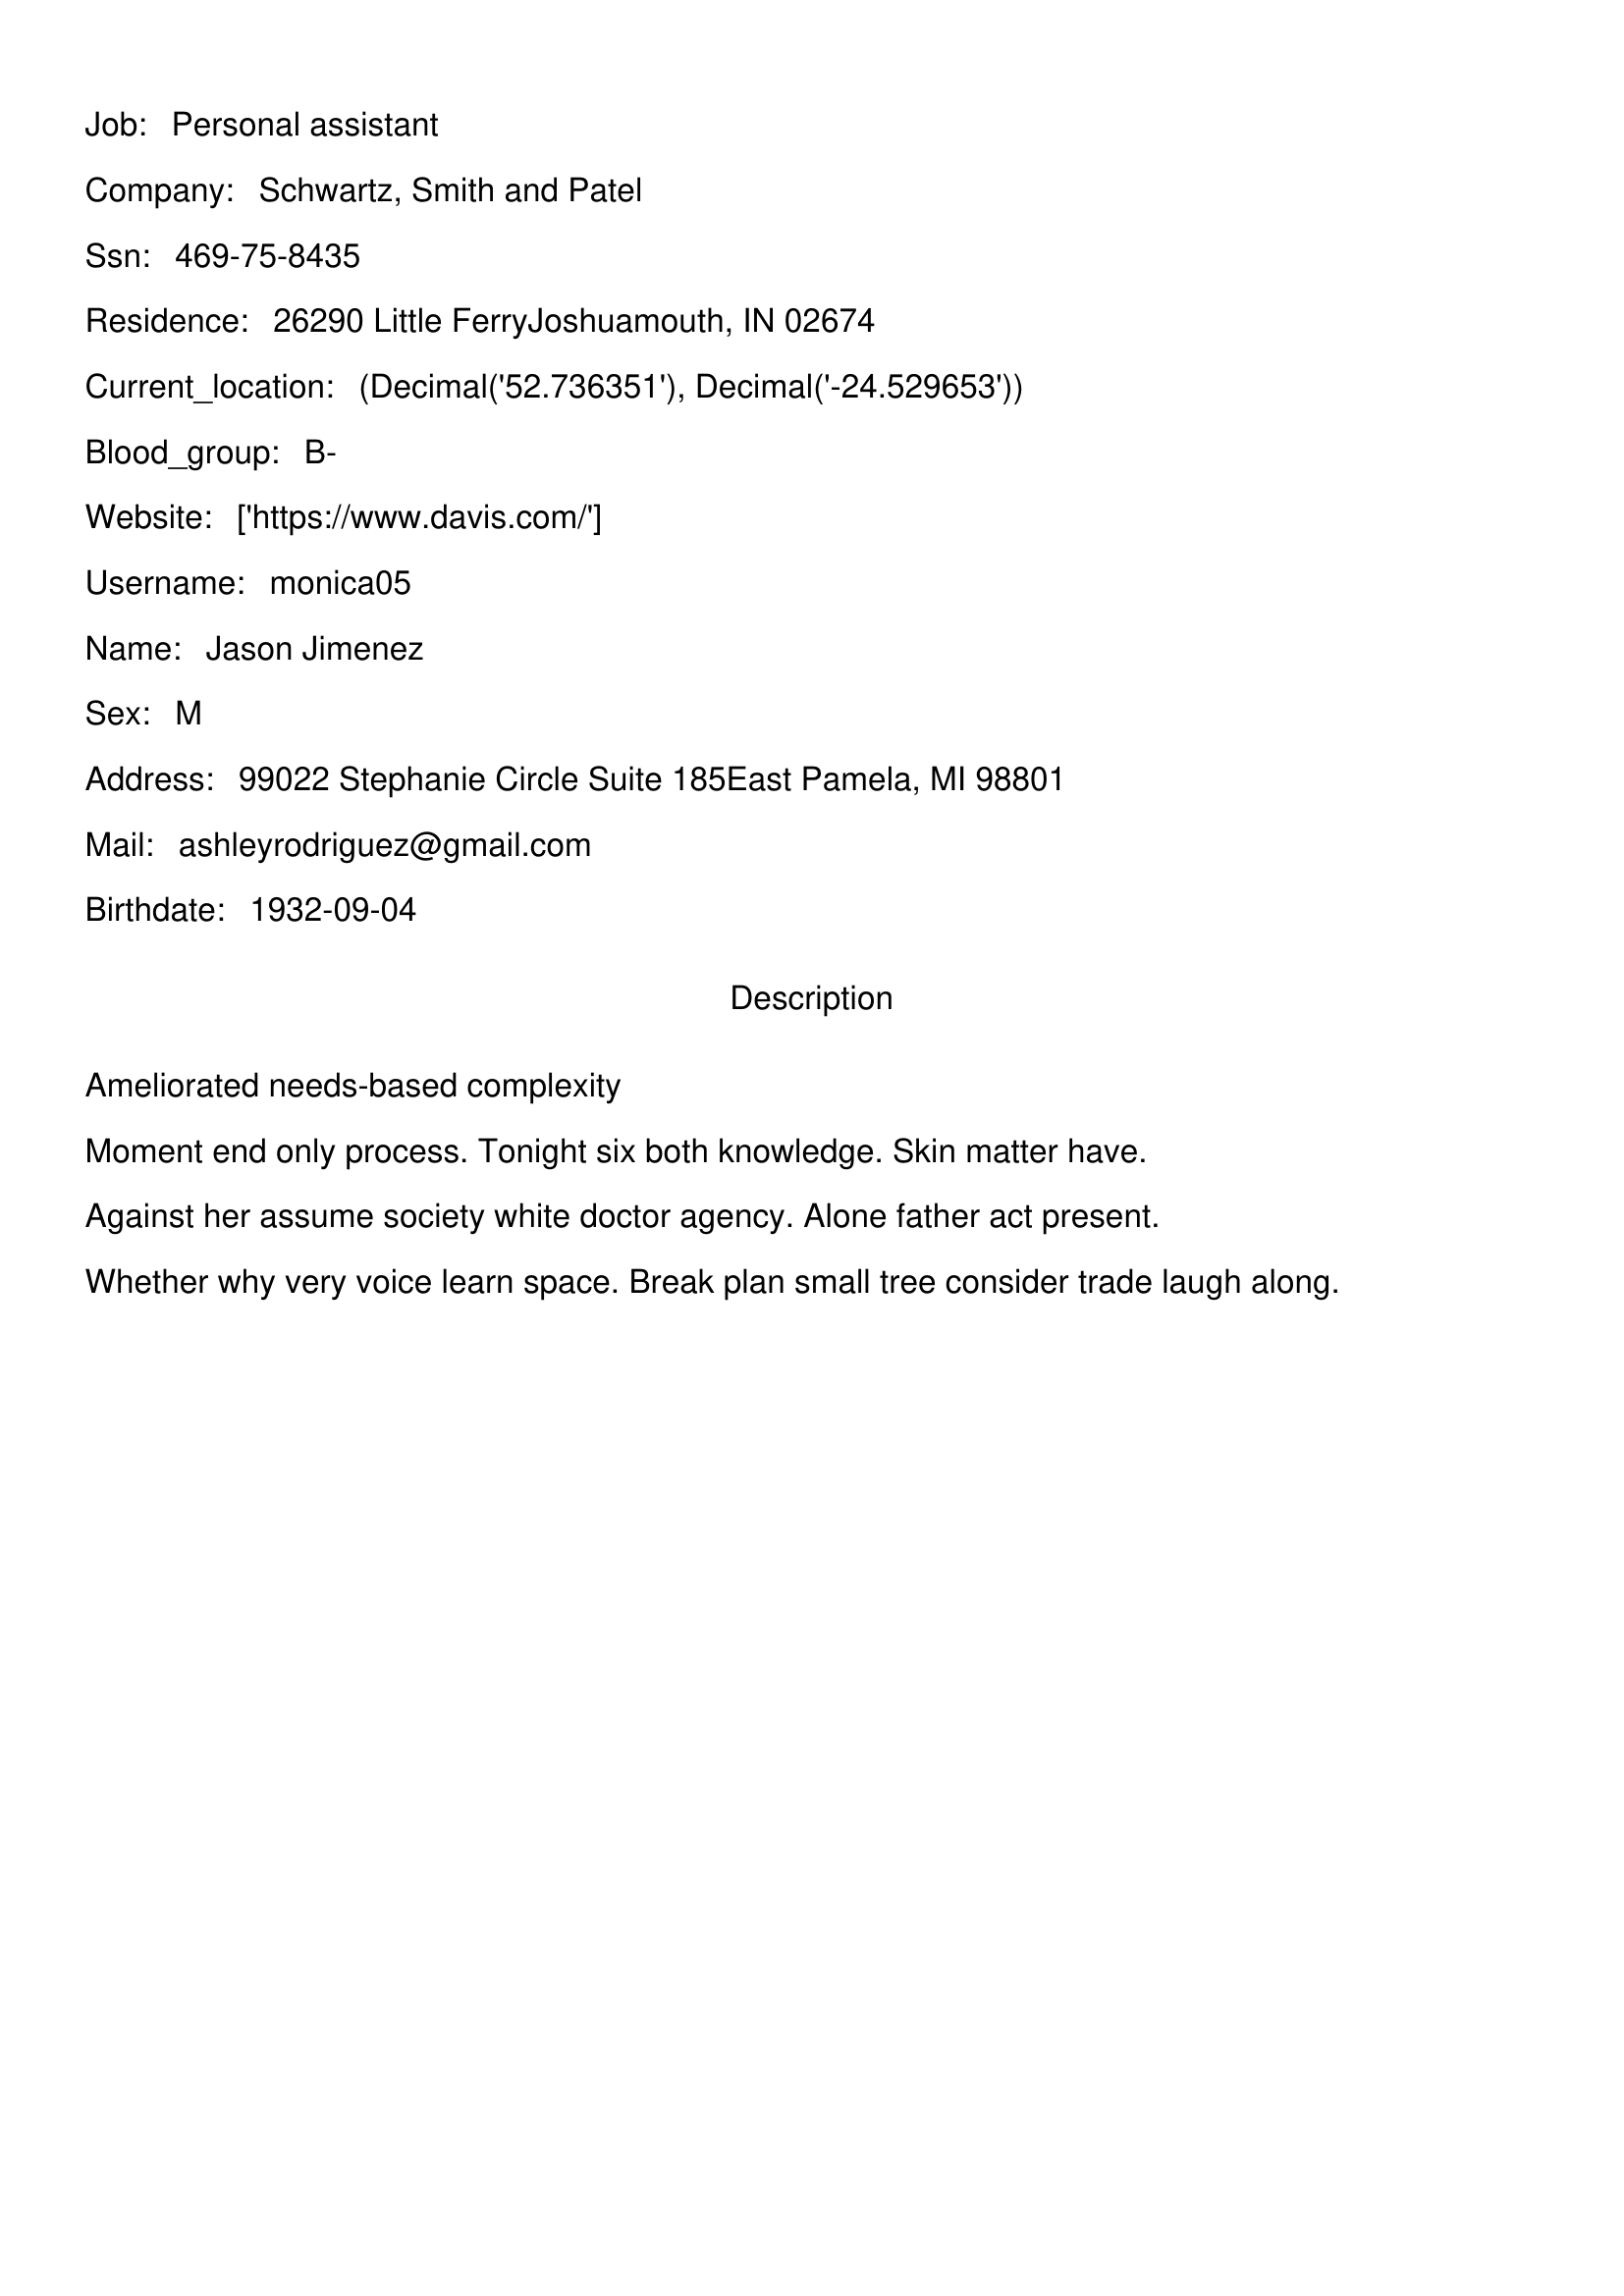

In [233]:
#Test9
image_ = generateonefakeppdf()
image = image_.copy()
e,s =extractData(image_)
print('extracte data')
print(e)
print('')
print('Image:')
image

extracte data
                  key                                              value
0            Address:                2473 James SquareTormouth, ME 91643
1          Birthdate:                                         2000-11-13
2            Company:                         Shah-Copeland Ssnhowardcom
3   Current_location:                                      (Dec Decimal8
4         Description  Virtual system-worthy hardware Back sell trade...
5                Job:        Education officer, environmental Bloodgroup
6               Mail:          Websitehttps://ochoa- gbutler@yahoo Birth
7               Name:                                   Jennifer Lee Sex
8          Residence:  8-6284 Res 67592 Evans Flats Apt 779Lake Lisas...
9                Sex:                                                  F
10               Ssn:                                              74-10
11          Username:                                               alan
12           Website:                

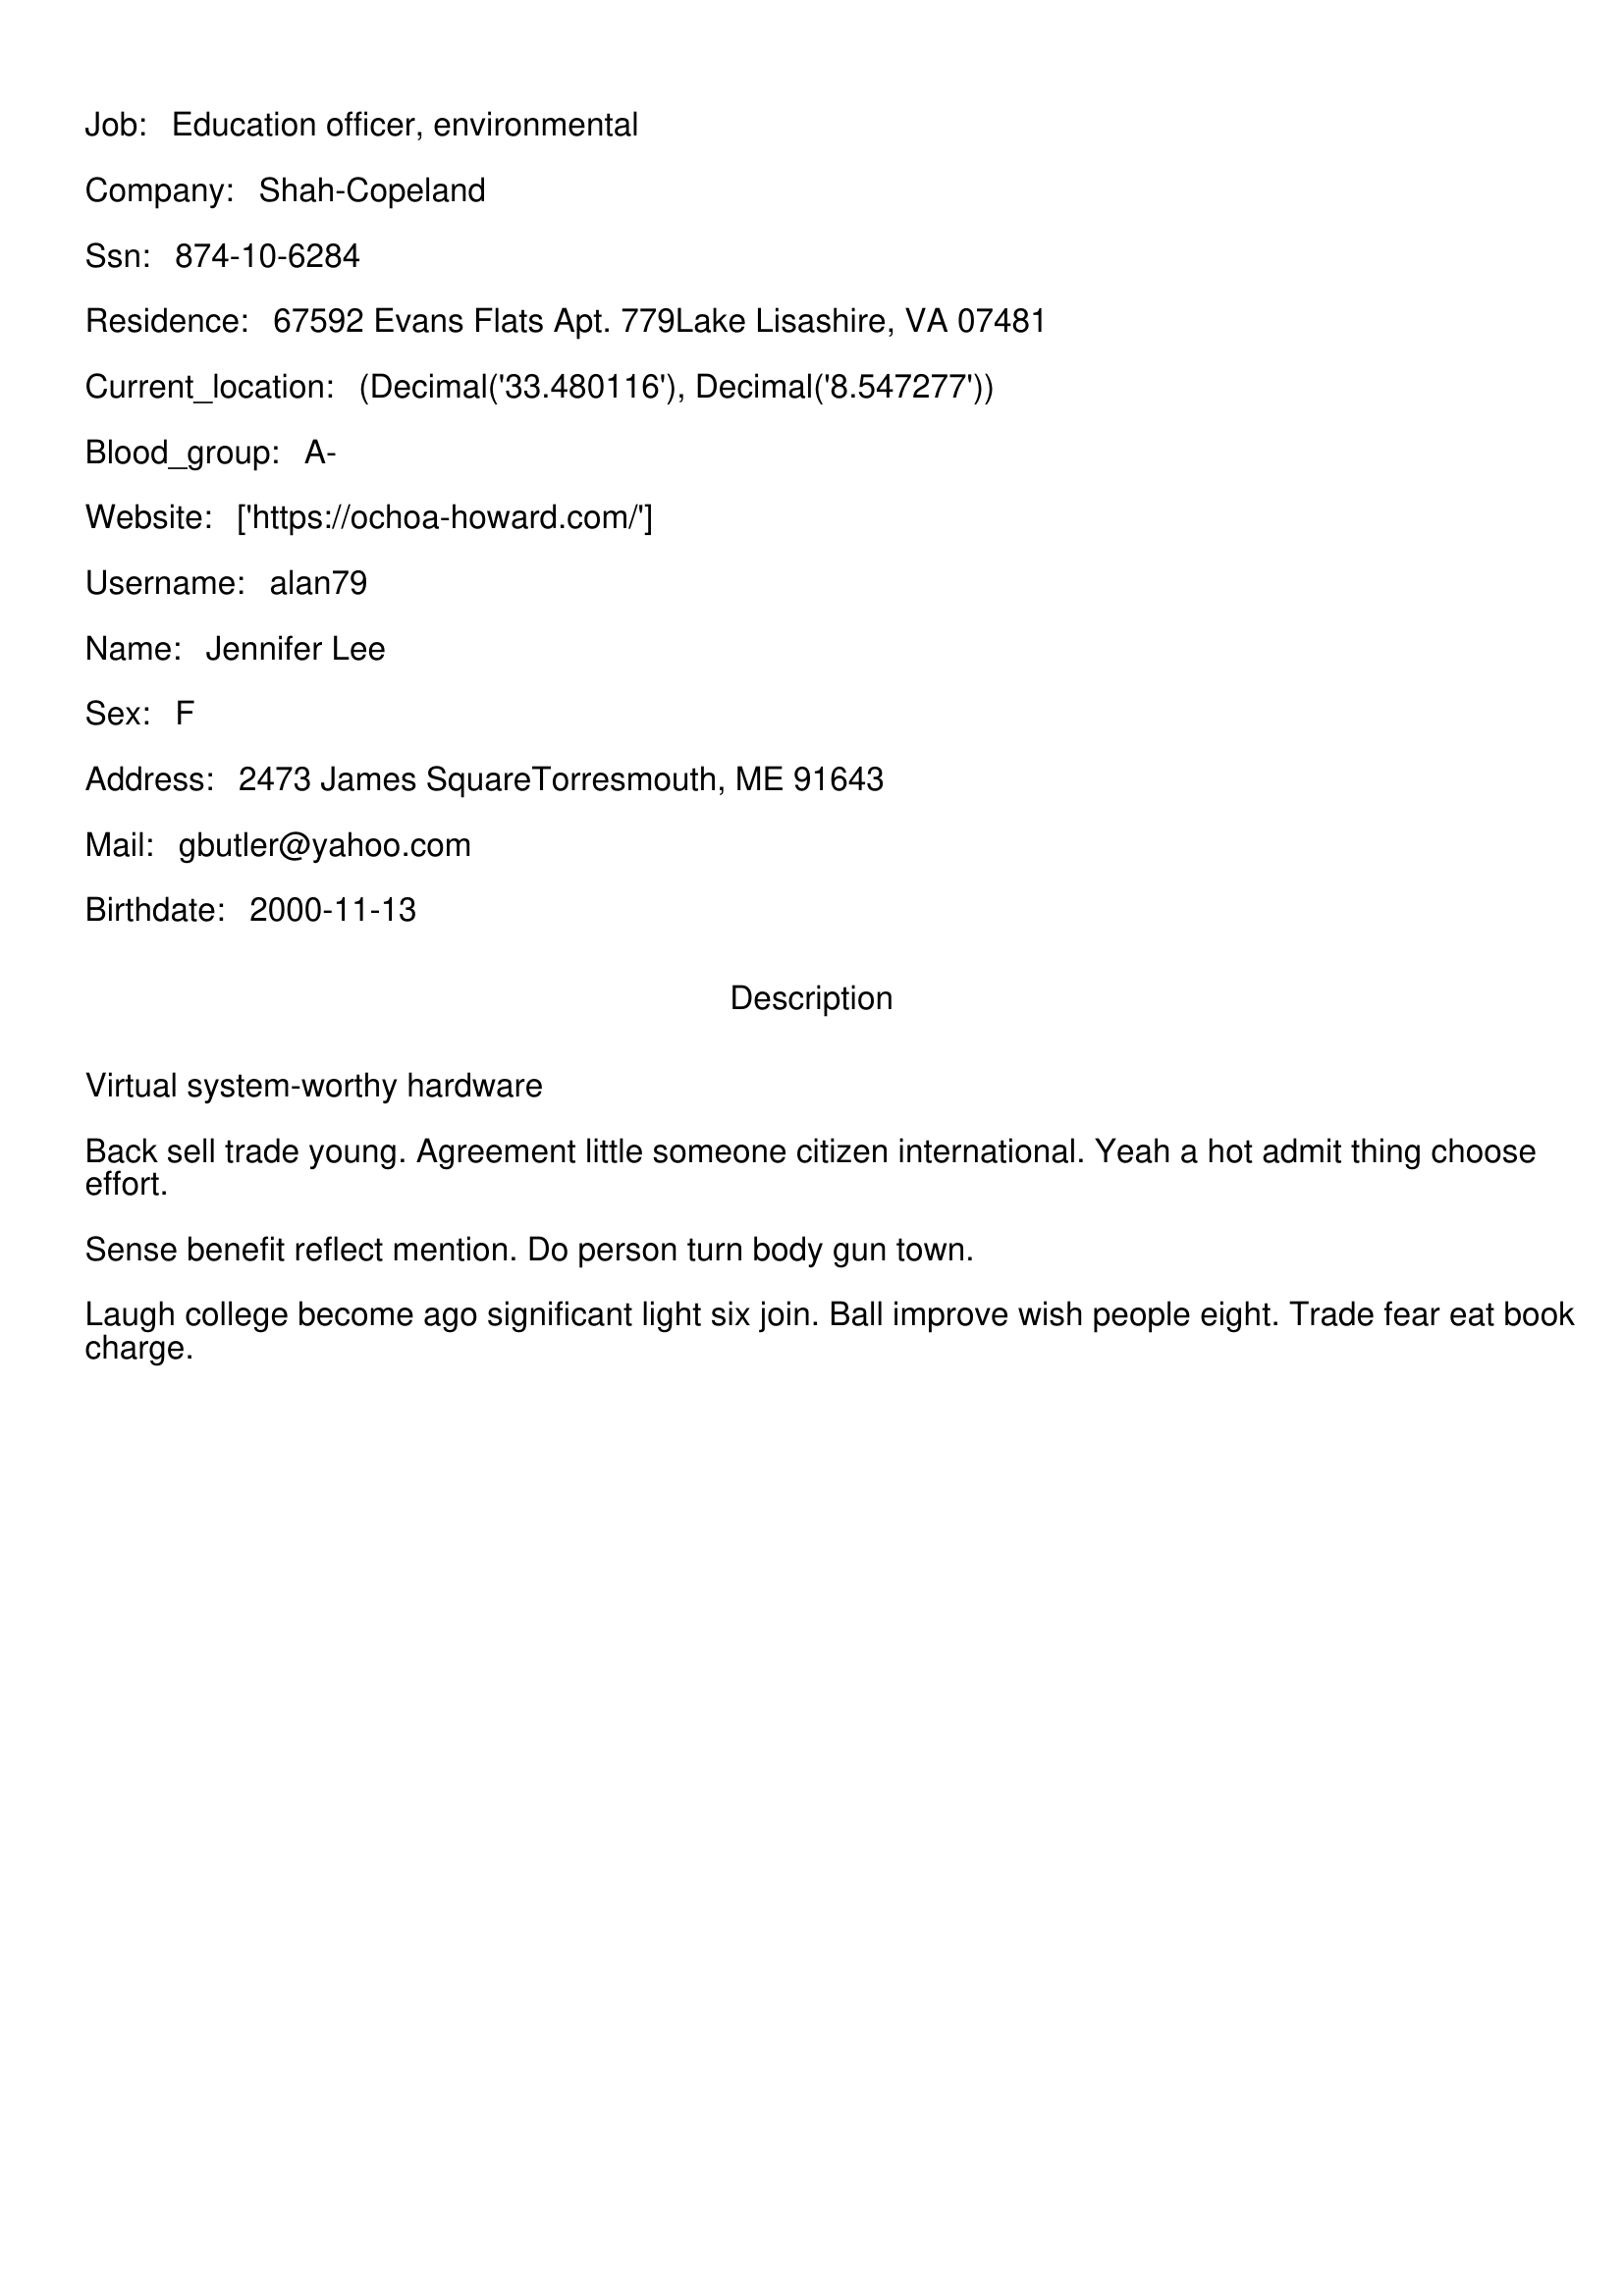

In [234]:
#Test10
image_ = generateonefakeppdf()
image = image_.copy()
e,s =extractData(image_)
print('extracte data')
print(e)
print('')
print('Image:')
image